# Introduction

Before we start, this notebook does not present a course on the models or the basics of Machine Learning. I strongly advise beginners not to start reading this methodological notebook without some knowledge about Machine Learning. 

Indeed, I often see on the Internet people who systematically try to get a very good score in their predictive model by neglecting some steps, especially in preprocessing. 

On Kaggle, if you see a score of 100%, this person has cheated. It is impossible in Machine Learning to have this score or rather that his model is purely and simply overfitting.

**Improving the score is not my main objective in this notebook. My goal is to propose a methodology on how to approach a dataset in order to obtain a generalizable predictive model.**

# I. Import libraries

Here are the libraries we will use in this notebook.

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Delete the outliers 
from collections import Counter 

# Data visualisation
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

# For the part Target Encoding
import string

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# For the encoding part (Feature transformation) and the standardization
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# For the modelling part
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Model evaluation
from sklearn.model_selection import cross_val_score

# Learning curve
from sklearn.model_selection import learning_curve

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# II. Import and read data

The data was imported via the Kaggle website, Titanic - Machine Learning from Disaster : https://www.kaggle.com/competitions/titanic/overview

You will need to download the 3 files: train.csv, test.csv and gender_submission.cvs

You don't have to use the data provided on Kaggle. The seaborn library also offers the dataset with some changes.

Personally, I highly recommend using the dataset offered by Kaggle because most of the time, the data is in this type of format.

In [2]:
# Returns a concatenated df of training and test set
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# Returns divided dfs of training and test set
def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# read_csv is a function from the library pandas to read csv files, you can read other files like Excel files for example
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

In [3]:
ss = pd.read_csv("gender_submission.csv")

In [4]:
# .head() is a function from pandas that returns the DataFrame with all the information you need.
# This function is very helpful to visualize your problem (shape errors, missing variables, etc.)

df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
# Always watch the test set to see if it is the same

df_test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [6]:
# .shape is a property from pandas that you will use everytime you have a shape error. 
# Always use .shape everytime you made a modification on your dataframe

print("Training set shape: ", df_train.shape)
print("Test set shape: ", df_test.shape)

Training set shape:  (891, 12)
Test set shape:  (418, 11)


In [7]:
df_all.shape

(1309, 12)

As you can see, the test set doesn't have the column "Survived" because it is our response variable or target variable. 

**The goal is to analyse the data in the training set and predict the survival of the passengers in the test set.**

In [8]:
ss.head(20)

PassengerId  Survived
0           892         0
1           893         1
2           894         0
3           895         0
4           896         1
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
15          907         1
16          908         0
17          909         0
18          910         1
19          911         1

In [9]:
ss.shape

(418, 2)

# III. Exploratory Data Analysis (EDA)

EDA is an approach to data analysis that focuses on discovering patterns, relationships, and trends in data using visual and descriptive techniques. The goal of EDA is to explore the data to uncover useful insights and generate new hypotheses to test.

EDA is often used at the beginning of a data analysis project to understand the structure and characteristics of the data before using more advanced techniques to model or predict outcomes. It can also be used throughout the project to refine models and hypotheses based on the results obtained.

## III. A. Data description

Here is the description of the dataset features. 

- PassengerId : An ID that doesn't have any effect on target


- Survived : 0 = Did not survive, 1 = Survived


- Pclass : Ticket class where 1 = First class, 2 = Second class, 3 = Third class. This can also be seen as a proxy for socio-economic status.


- Sex : Male or female


- Age : Age in years, fractional if less than 1


- SibSp : Number of siblings or spouses aboard the titanic


- Parch : Number of parents or children aboard the titanic


- Ticket : Passenger ticket number


- Fare : Passenger fare


- Cabin : Cabin number


- Embarked : Point of embarkation where C = Cherbourg, Q = Queenstown, S = Southampton


- Name : Passenger name with their title

We do not count PassengerID and Survived.

The categorical variables are : Name, Sex, Ticket, Cabin and Embarked.

The numerical variables are : Pclass, Age, SibSp, Parch and Fare.

## III. B. Data types

Data types are usefull to identify numerical and categorial variables for the feature analysis.

In [10]:
# Non-null count and data types of the training set
# .info is an usefull function that prints a concise summary of a dataframe

print(df_train.info())
df_train.sample(3)
print()
df_train.dtypes.value_counts() # value_counts() will count the dtype for you

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None



int64      5
object     5
float64    2
dtype: int64

In [11]:
# Non-null count and data types of the test set

print(df_test.info())
df_test.sample(3)
print()
df_test.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None



object     5
int64      4
float64    2
dtype: int64

## III. C. Summary statistics 

Summary statistics in preprocessing provide a summary of basic characteristics of a dataset, such as the distribution of data and the presence of outliers, missing or null values, and correlations. They help understand the data, identify patterns and anomalies, and guide the selection of machine learning algorithms.

In [12]:
df_all.describe()

Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027   655.000000     2.294882   
std      14.413493    51.758668     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.895800     0.000000   328.000000     2.000000   
50%      28.000000    14.454200     0.000000   655.000000     3.000000   
75%      39.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

             SibSp    Survived  
count  1309.000000  891.000000  
mean      0.498854    0.383838  
std       1.041658    0.486592  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    1.000000  
max       8.000000    1.000000

## III. D. Missing data

In [13]:
# Missing data using the function sum()

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




<AxesSubplot:>

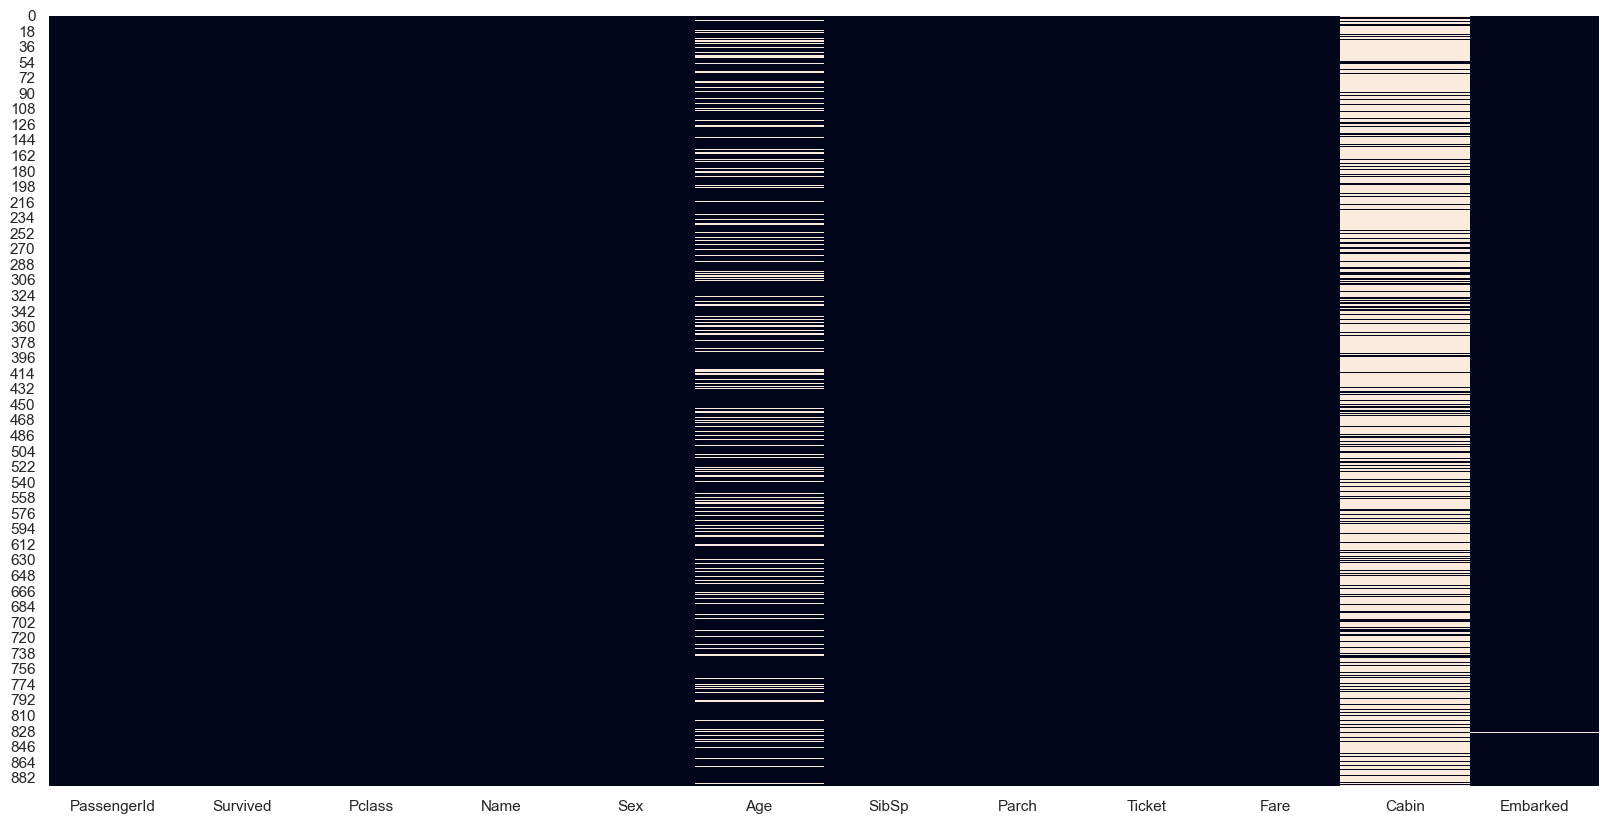

In [14]:
# Visualize the missing data for the train set

plt.figure(figsize=(20, 10))
sns.heatmap(df_train.isna(), cbar=False) # The color bar in the right will not appear

<AxesSubplot:>

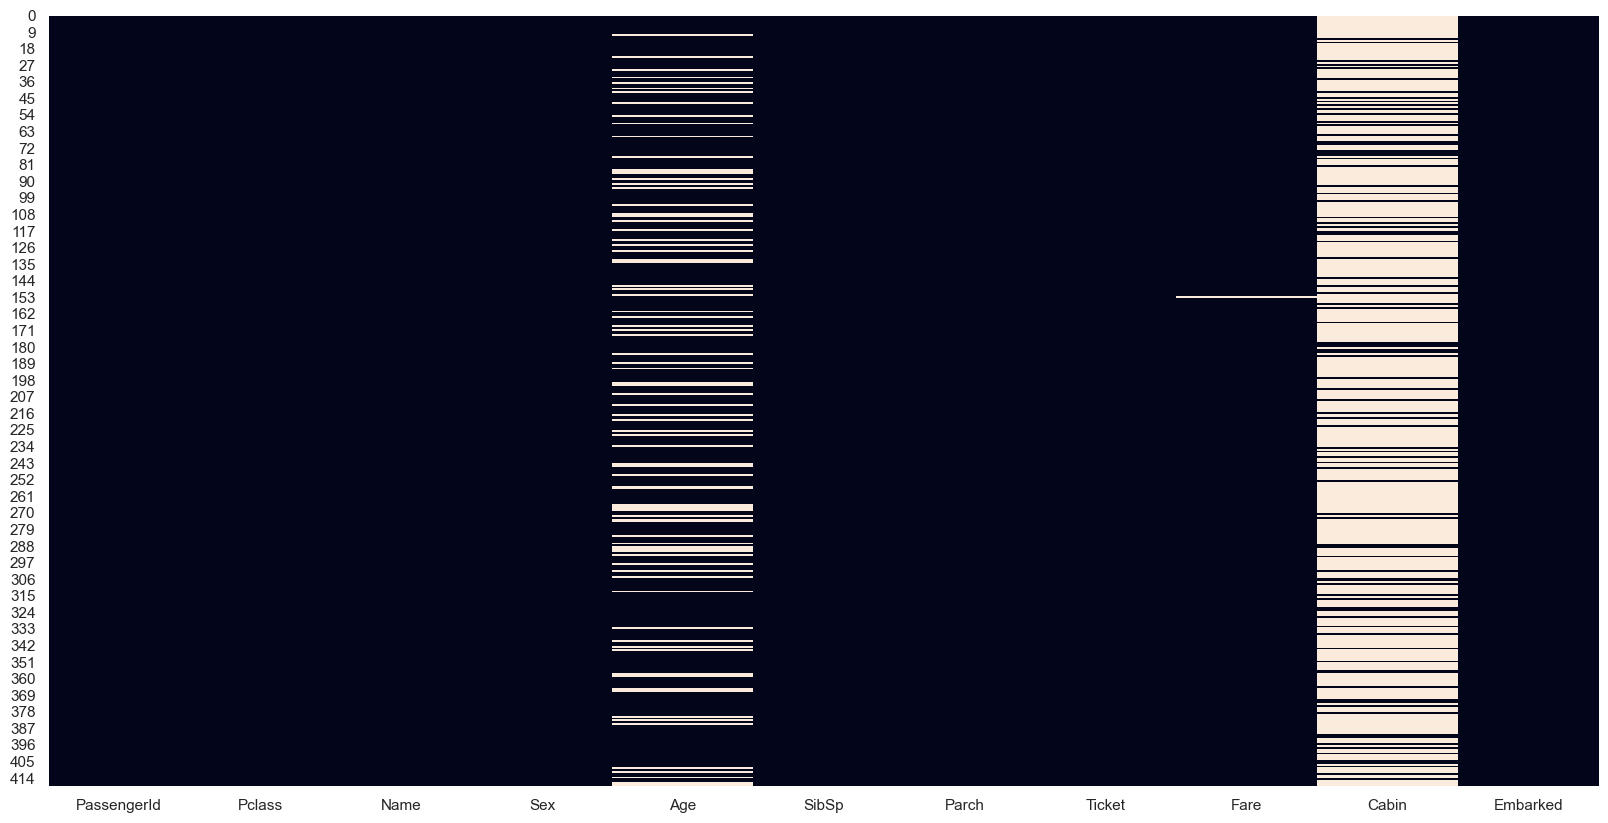

In [15]:
# Visualize the missing data for the test set

plt.figure(figsize=(20, 10))
sns.heatmap(df_test.isna(), cbar=False) # The color bar in the right will not appear

In [16]:
# Percentage of missing values for the train set

((df_all.isna().sum()/df_all.shape[0])*100).sort_values(ascending=True) 

Name            0.000000
Parch           0.000000
PassengerId     0.000000
Pclass          0.000000
Sex             0.000000
SibSp           0.000000
Ticket          0.000000
Fare            0.076394
Embarked        0.152788
Age            20.091673
Survived       31.932773
Cabin          77.463713
dtype: float64

I would recommand to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. 

The number of missing values in Age, Embarked, and Fare is relatively small compared to the total sample. However, around 77.5% of the Cabin feature is missing. Descriptive statistical measures can be used to fill in the missing values for Age, Embarked, and Fare, but this approach is not applicable for the Cabin feature.

## III. E. Filling missing values

### III. E. 1. Age

Replacing missing Age values with the median age of the whole dataset is not an optimal solution. A better approach is to use the median age of each Pclass group since it has a higher correlation with both Age (0.408106) and Survived (0.338481). Age grouping by passenger class is also more reasonable than using other variables.

In [17]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

Feature 1    Feature 2  Correlation Coefficient
0        Age          Age                 1.000000
9        Age       Pclass                 0.408106
18       Age        SibSp                 0.243699
21       Age         Fare                 0.178740
26       Age        Parch                 0.150917
30       Age     Survived                 0.077221
41       Age  PassengerId                 0.028814

To increase the score, the Sex feature is used as a second level of grouping when filling missing Age values. Pclass and Sex groups have distinct median Age values, with median age increasing as passenger class increases for both males and females. However, females tend to have slightly lower median ages than males. These median ages are used to fill missing Age values.

In [18]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


### III. E. 2. Embarked

Embarked is a categorical feature with only 2 missing values. Both passengers are female, upper class, and share the same ticket number, indicating that they know each other and embarked from the same port. The most common Embarked value for upper class females is C (Cherbourg), but it is not certain that this is where they embarked.

In [19]:
df_all[df_all['Embarked'].isnull()]

Age Cabin Embarked  Fare                                       Name  \
61   38.0   B28      NaN  80.0                        Icard, Miss. Amelie   
829  62.0   B28      NaN  80.0  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId  Pclass     Sex  SibSp  Survived  Ticket  
61       0           62       1  female      0       1.0  113572  
829      0          830       1  female      0       1.0  113572

After searching for Stone, Mrs. George Nelson (Martha Evelyn) on Google, it was discovered that she embarked from S (Southampton) with her maid Amelie Icard, according to the page Martha Evelyn Stone: Titanic Survivor.

_Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28._ 

Missing values in Embarked are filled with S with this information.

In [20]:
# Filling the missing values in Embarked with S

df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [21]:
df_all.loc[62, 'Embarked'] # To see if she is filled with 'S'

'S'

### III. E. 3. Fare

There is only one passenger with a missing Fare value. It can be assumed that Fare is related to family size (Parch and SibSp) and Pclass. The median Fare value for a male with a third class ticket and no family is a logical choice for filling the missing value.

In [22]:
df_all[df_all['Fare'].isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
1043  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket  
1043       3  male      0       NaN   3701

In [23]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

# Filling the missing value in Fare with the median Fare of 3rd class alone passenger

df_all['Fare'] = df_all['Fare'].fillna(med_fare)

### III. E. 4. Cabin

The Cabin feature is complex and requires additional investigation. While a significant portion of the Cabin values are missing, the feature cannot be disregarded entirely since some cabins may have a higher survival rate. 

Interestingly, the first letter of the Cabin values corresponds to the decks where the cabins are situated. These decks were primarily designated for a single passenger class, although some were utilized by multiple classes.

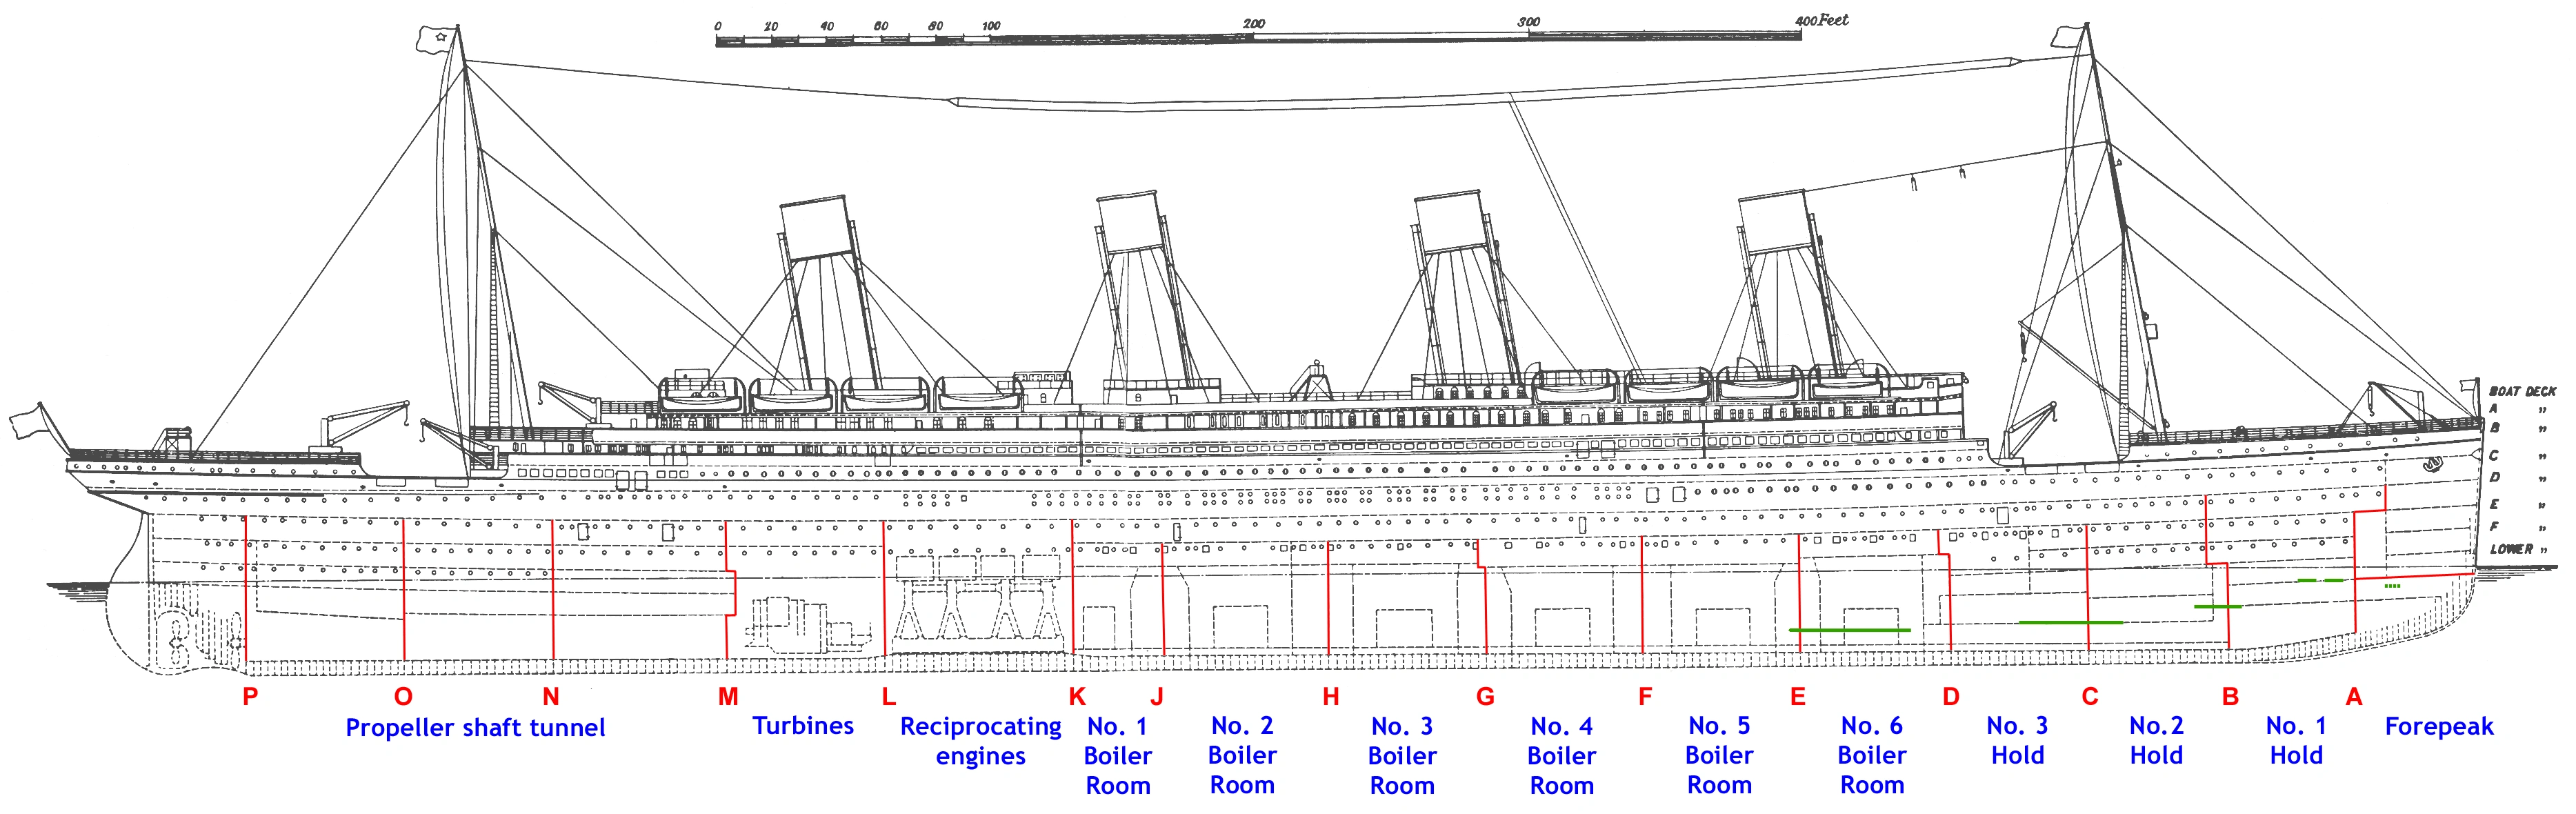

- On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset.


- A, B and C decks were only for 1st class passengers.


- D and E decks were for all classes.


- F and G decks were for both 2nd and 3rd class passengers.


- From going A to G, distance to the staircase increases which might be a factor of survival.

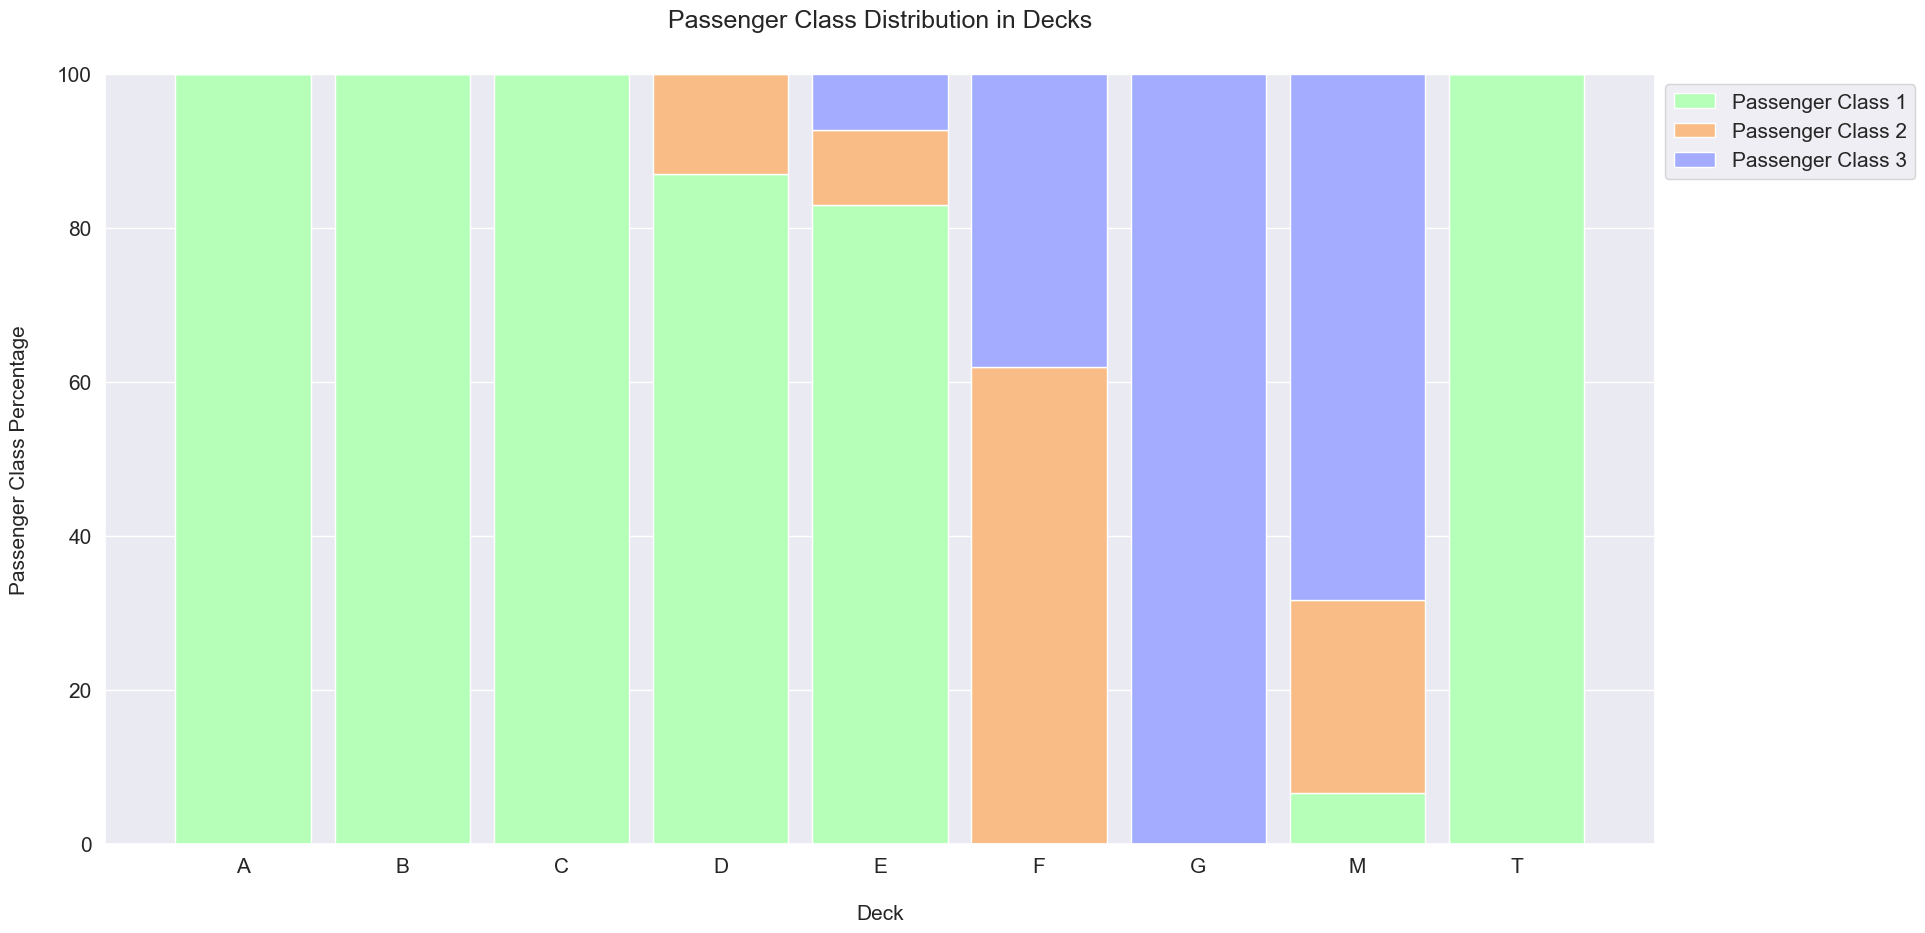

In [24]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)

df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

- 100% of A, B and C decks are 1st class passengers.


- Deck D has 87% 1st class and 13% 2nd class passengers.


- Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers.


- Deck F has 62% 2nd class and 38% 3rd class passengers.


- 100% of G deck are 3rd class passengers.


-  There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck.


- Passengers labeled as M are the missing values in Cabin feature. I don't think it is possible to find those passengers' real Deck so I decided to use M like a deck.

In [25]:
# Passenger in the T deck is changed to A

idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

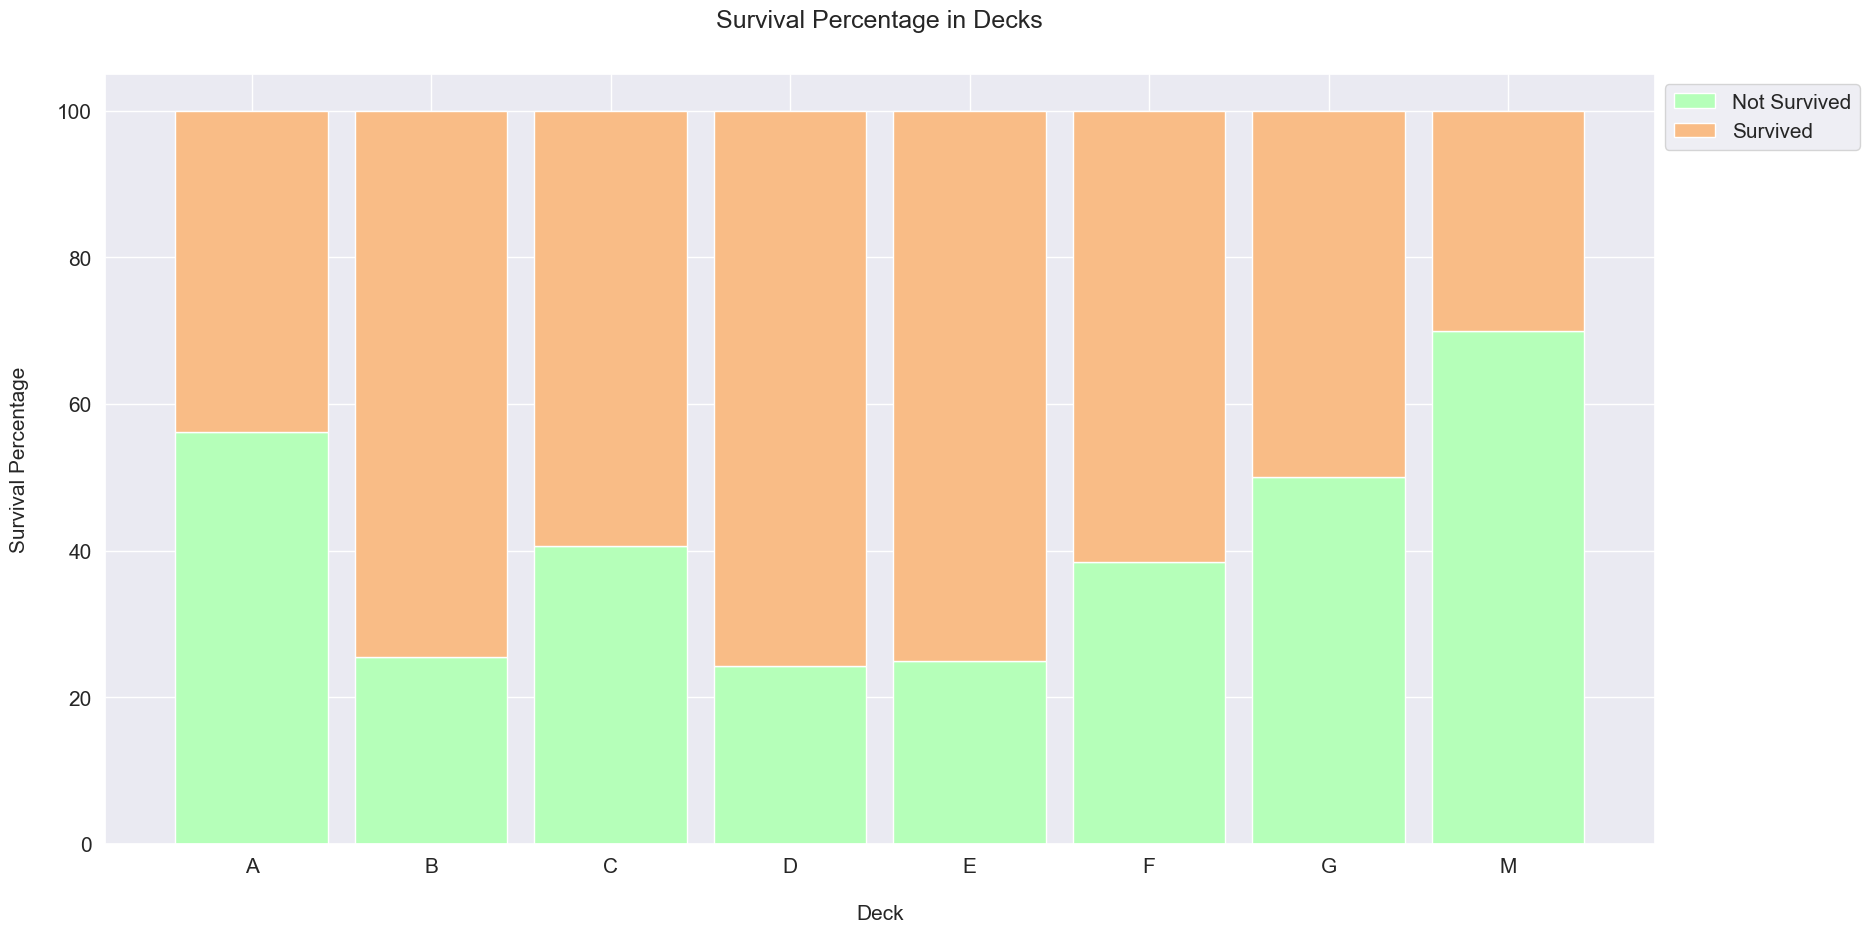

In [26]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, the survival rates vary among the different decks, which is valuable information that cannot be dismissed. Decks B, C, D, and E have the highest survival rates and are mostly occupied by 1st class passengers. On the other hand, deck M has the lowest survival rate and is mostly occupied by 2nd and 3rd class passengers. 

In my view, the missing values for cabins are likely victims whose cabin data was unable to be retrieved. Therefore, labeling them as M and treating them as a separate group with shared characteristics is a reasonable approach to managing the missing data. Currently, the deck feature has high cardinality, so some values are grouped together based on their similarities.

- A, B and C decks are labeled as ABC because all of them have only 1st class passengers.


- D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate.


- F and G decks are labeled as FG because of the same reason above.


- M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [27]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

After filling the missing values in Age, Embarked, Fare and Deck features, there is no missing value left in both training and test set. Cabin is dropped because Deck feature is used instead of it.

In [28]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




## III. F. Feature analysis

Feature analysis is the process of examining the data features to identify the most relevant ones for a particular machine learning problem.

### III. F. 1. Target Distribution

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


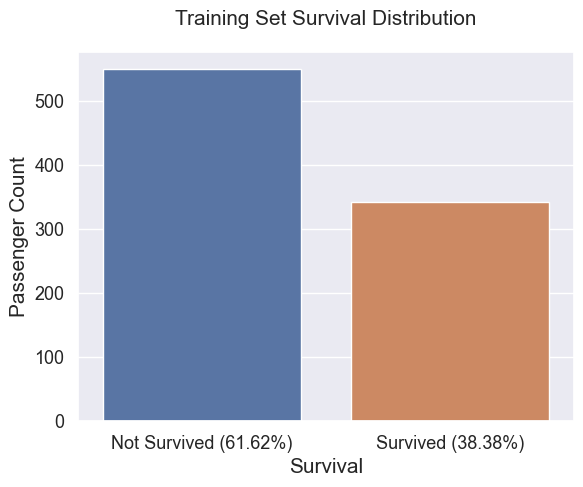

In [29]:
# Calculate survival statistics
survived = df_train['Survived'].sum()
not_survived = df_train['Survived'].count() - survived
survived_per = survived / df_train['Survived'].count() * 100
not_survived_per = not_survived / df_train['Survived'].count() * 100

# Print the results of the survival statistics
print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(int(survived), len(df_train), survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(int(not_survived), len(df_train), not_survived_per))

# Plot survival distribution
sns.countplot(x='Survived', data=df_train)
plt.xlabel('Survival', size=15)
plt.ylabel('Passenger Count', size=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='both', labelsize=13)
plt.title('Training Set Survival Distribution', size=15, y=1.05)
plt.show()

### III. F. 2. Correlations

Correlation measures the linear relationship between two variables. It can range from -1 to 1, where a correlation of -1 indicates a perfect negative linear relationship, 0 indicates no linear relationship, and 1 indicates a perfect positive linear relationship. 

Correlation can be used to explore the relationship between different variables in a dataset and can help identify the most relevant features for a predictive model.

In [30]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [31]:
# Training set high correlations

corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

Feature 1 Feature 2  Correlation Coefficient
6       Fare    Pclass                 0.549500
8        Age    Pclass                 0.417667
10     Parch     SibSp                 0.414838
12    Pclass  Survived                 0.338481
14      Fare  Survived                 0.257307
16       Age     SibSp                 0.249747
18     Parch      Fare                 0.216225
20     Parch       Age                 0.176733
22     SibSp      Fare                 0.159651
24       Age      Fare                 0.124061

In [32]:
# Test set high correlations

corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

Feature 1 Feature 2  Correlation Coefficient
6     Pclass      Fare                 0.577489
8        Age    Pclass                 0.526789
10       Age      Fare                 0.345347
12     SibSp     Parch                 0.306895
14     Parch      Fare                 0.230410
16      Fare     SibSp                 0.172032

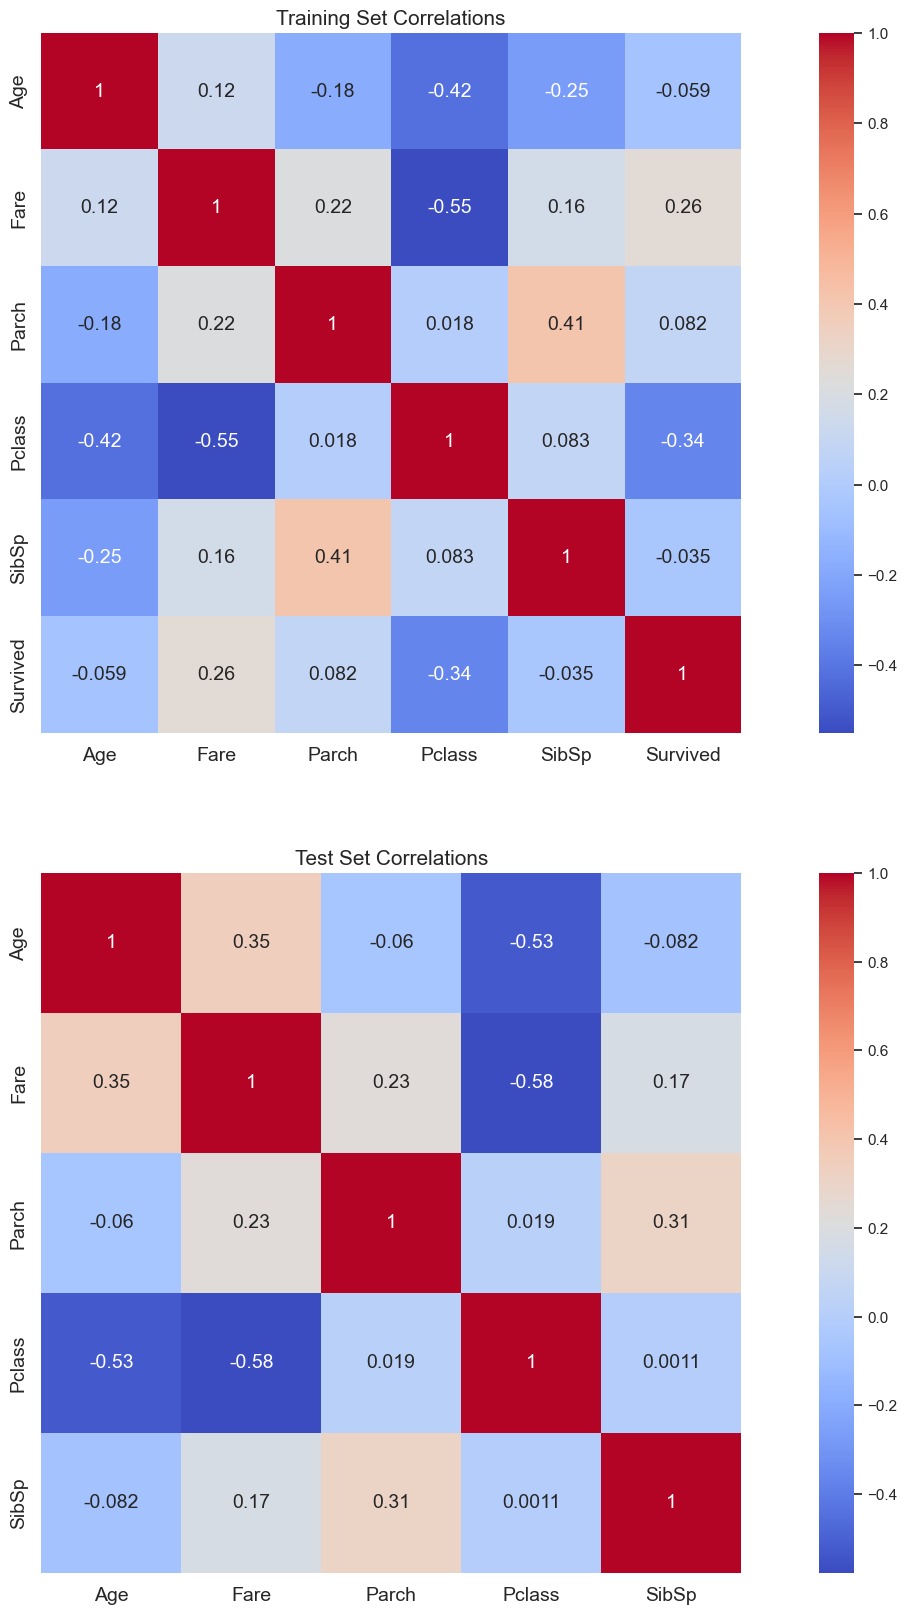

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### III. F. 3. Target Distribution in Features

#### III. F. 3. a. Continuous Features

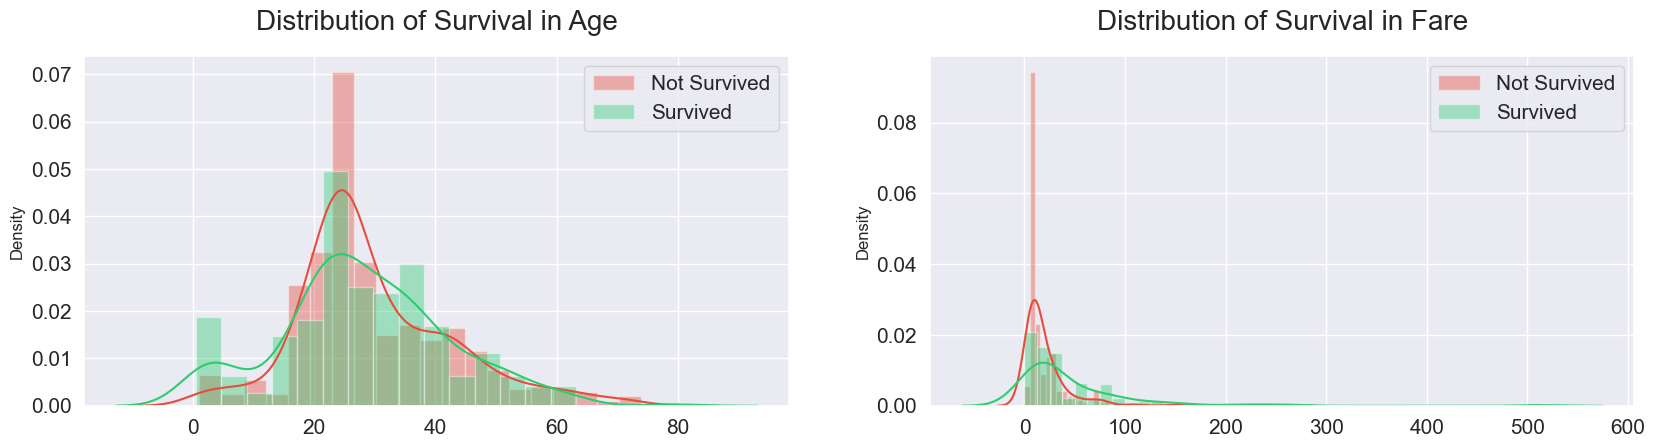

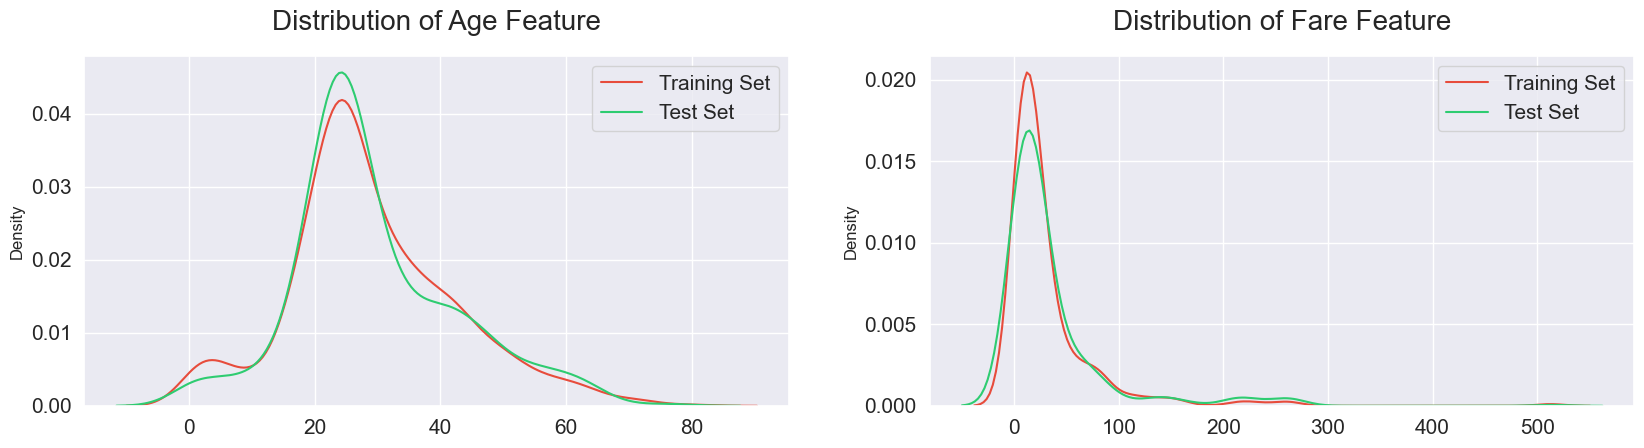

In [34]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

plt.figure(figsize=(20, 10))

for i, feature in enumerate(cont_features):
    plt.subplot(2, 2, i+1)
    plt.title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)
    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c')
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71')
    
    plt.xlabel('')
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper right', prop={'size': 15})
    
plt.figure(figsize=(20, 10))

for i, feature in enumerate(cont_features):
    plt.subplot(2, 2, i+1)
    plt.title('Distribution of {} Feature'.format(feature), size=20, y=1.05)
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c')
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71')
    
    plt.xlabel('')
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper right', prop={'size': 15})

Both of the continuous features (Age and Fare) exhibit distinct split points and spikes, which can be effectively utilized by a decision tree model.

However, a potential issue with both features is that the distribution in the training set contains more spikes and bumps compared to the smoother distribution in the test set, which may hinder the model's generalization to new data.

The Age feature distribution highlights that children under the age of 15 have a considerably higher survival rate than other age groups.

The Fare feature distribution displays a higher survival rate in the tails of the distribution, indicating that passengers who paid a higher fare had a better chance of surviving. Additionally, the distribution is positively skewed due to the presence of extremely large outliers.

#### III. F. 3. b. Categorical Features

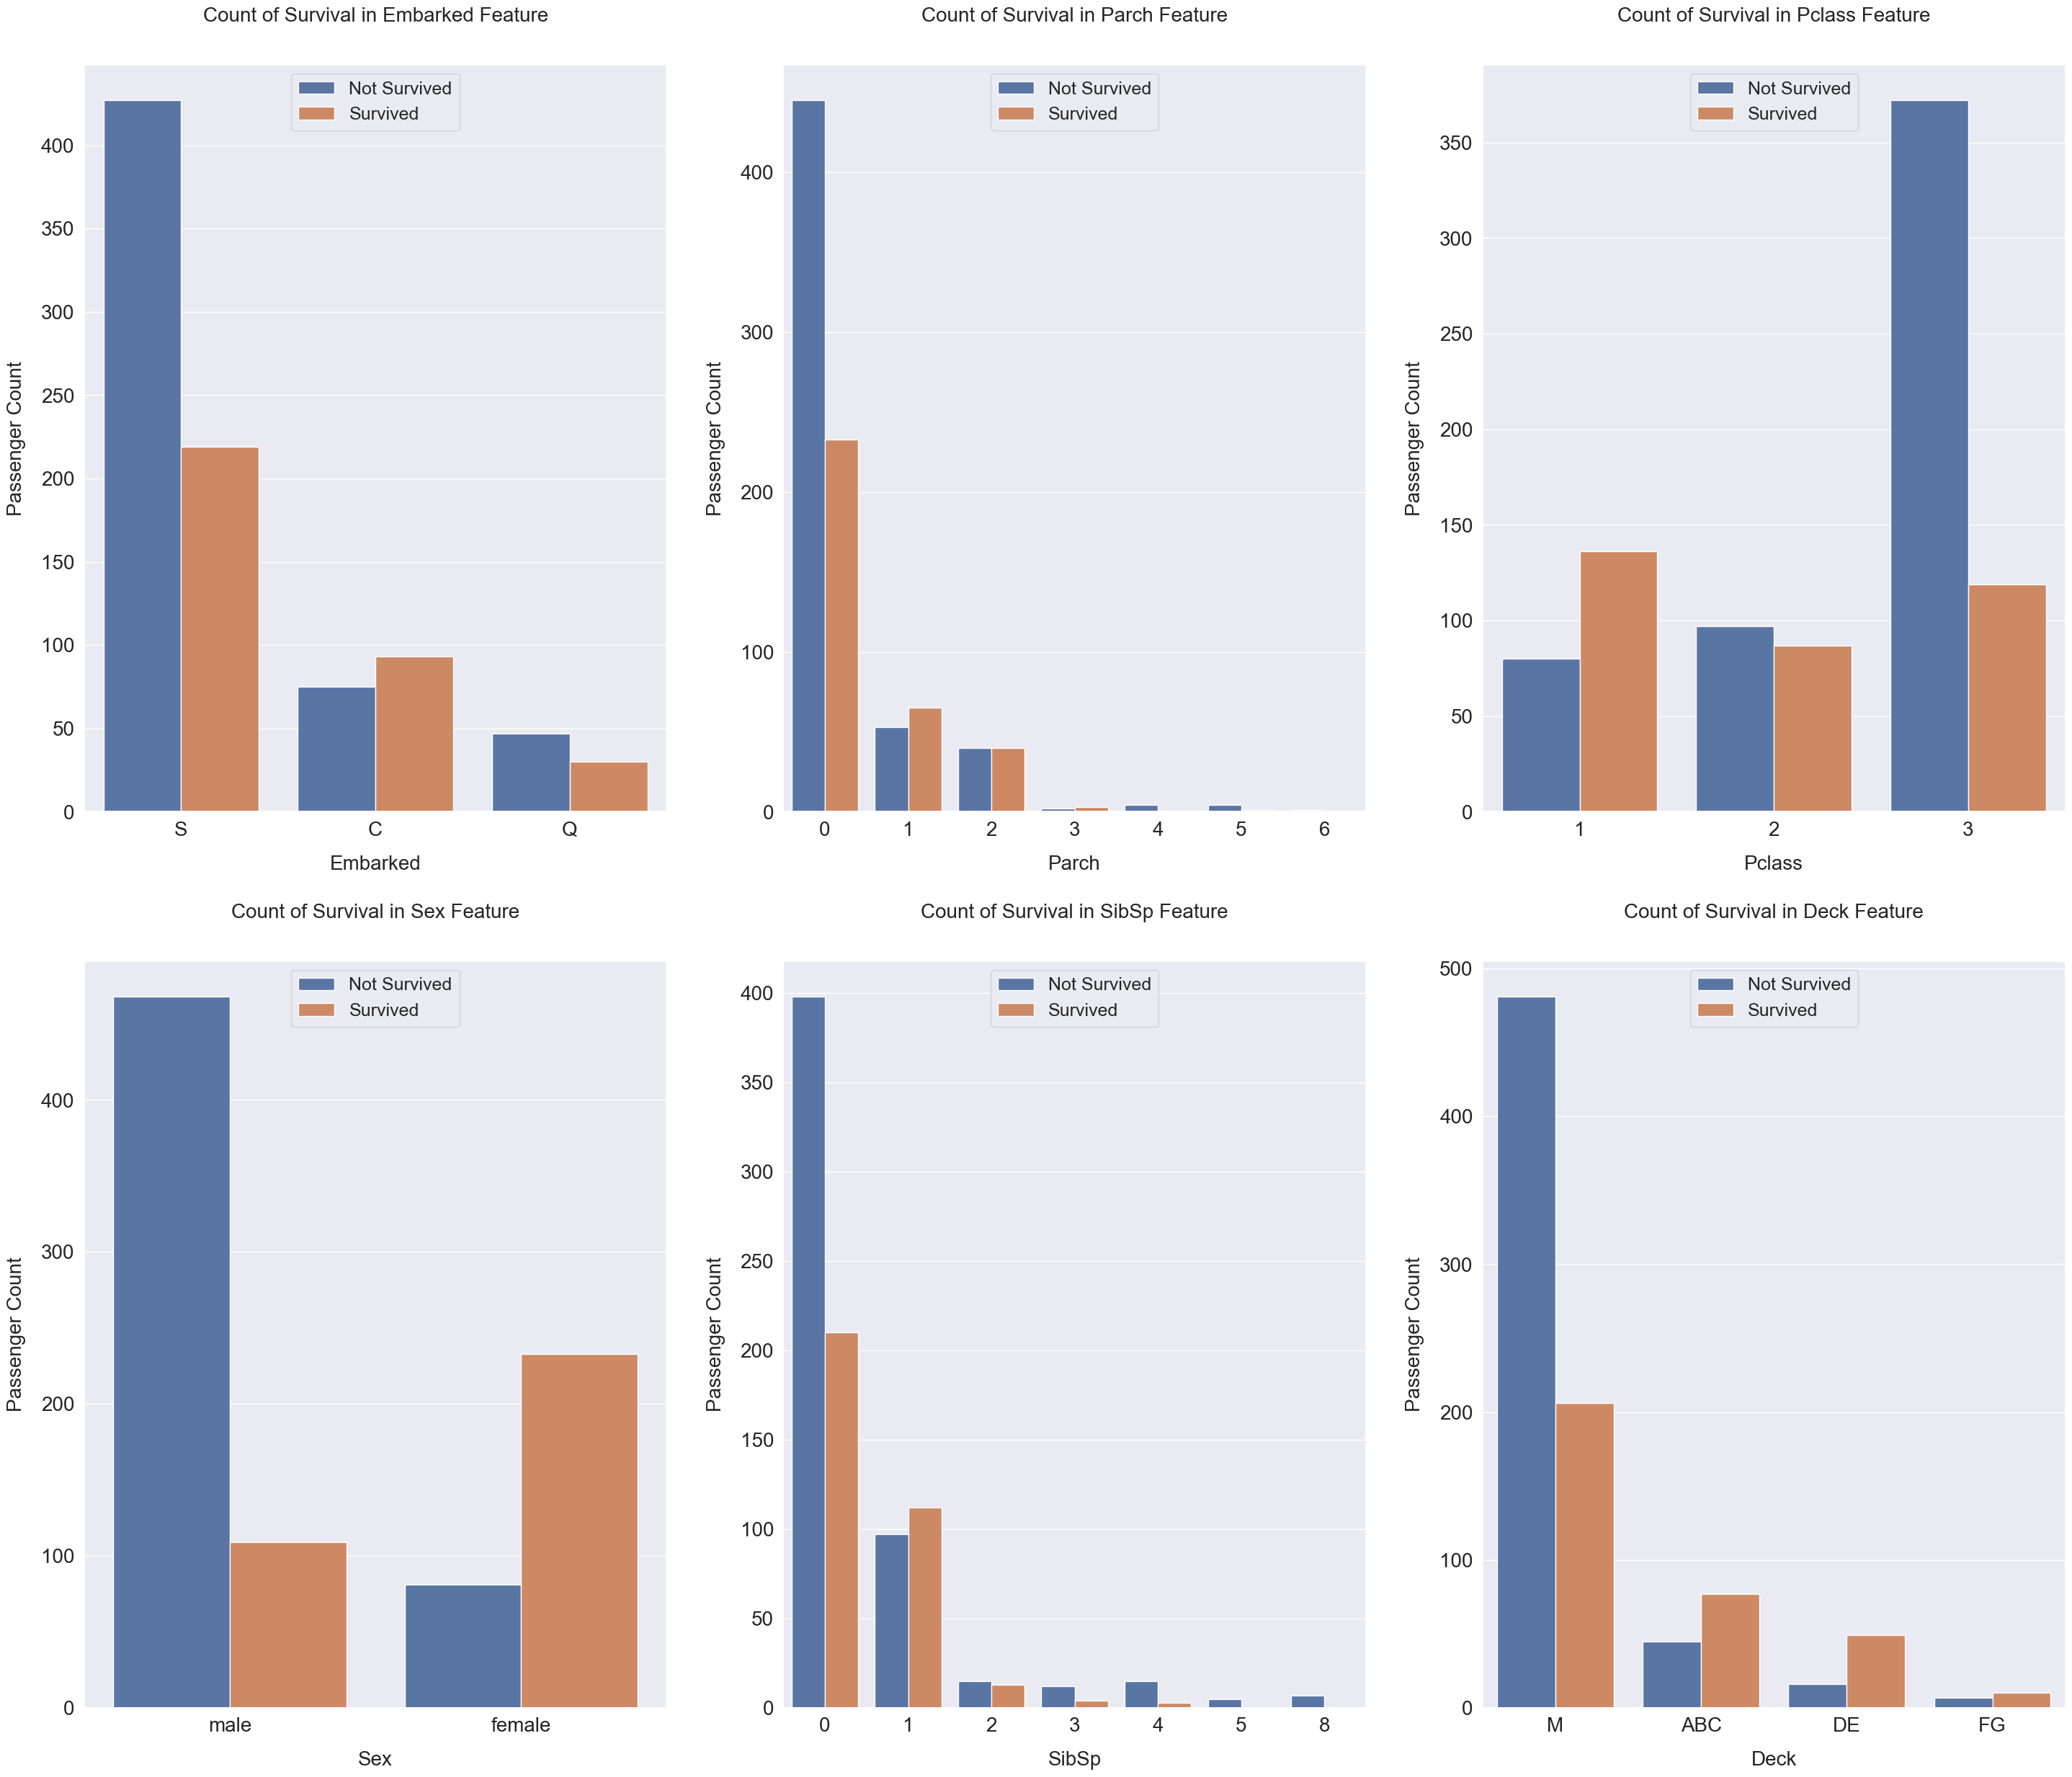

In [35]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

At least one class with high mortality rate can be found in every categorical feature, making them valuable in predicting passenger survival. Pclass and Sex are the most useful categorical features due to their more uniform distributions.

The Parch and SibSp features reveal that passengers with only one family member have a higher survival rate.

Passengers boarding from S had a lower survival rate compared to those from other ports, with over half of the passengers from C surviving.

One possible explanation for this could be that the majority of first-class passengers embarked from location C, and since first-class passengers had a higher survival probability, this resulted in location C having the highest overall survival probability. 

On the other hand, it’s possible that more third-class passengers embarked from location S, and since third-class passengers had the lowest survival probability, this resulted in location S having the lowest overall survival probability. We can test this hypothesis to see if it is supported by the data.

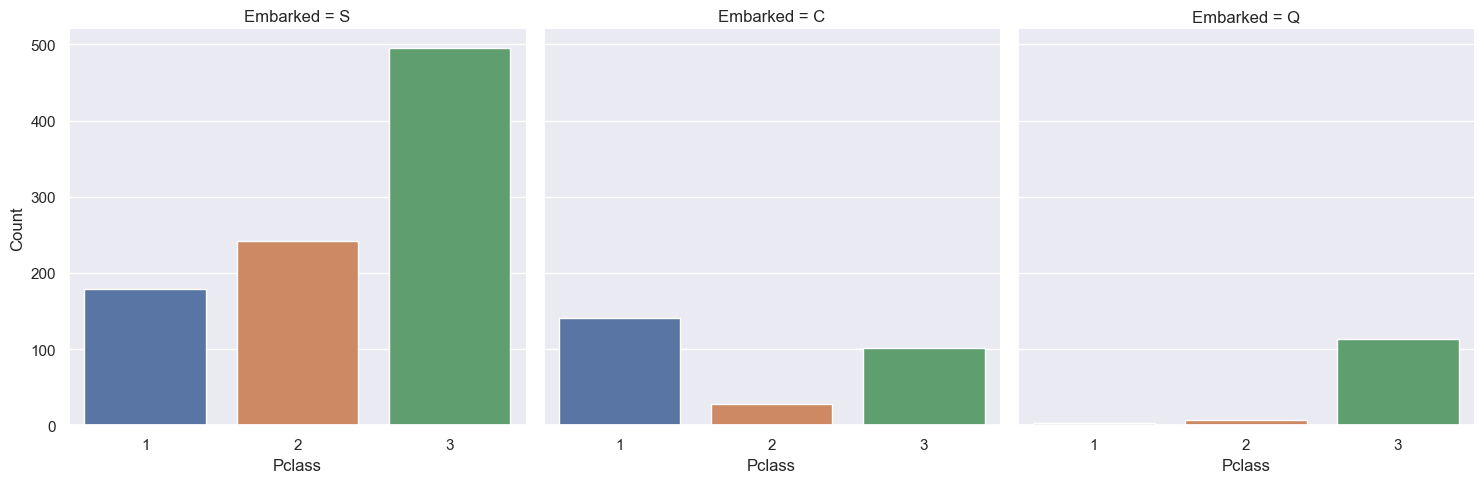

In [36]:
g = sns.catplot(x='Pclass', col='Embarked', data=df_all, kind='count')
g.set_ylabels('Count')

Our hypothesis appears to be true. Location S has the most third-class passengers whereas location C has the most first-class passengers.

## III. G. Conclusion

The majority of features exhibit correlations with one another, which can be leveraged for feature transformation and interaction to create new features. Given the high correlations with the target Survived feature, target encoding may also be useful.

Continuous features display split points and spikes, which are easily captured by decision tree models, but may be missed by linear models.

Categorical features have distinct distributions with varying survival rates, making them good candidates for one-hot encoding. Additionally, some of these features can be combined to create new features.

Lastly, a new feature called Deck was created and the Cabin feature was dropped during the Exploratory Data Analysis stage.

In [37]:
df_all = concat_df(df_train, df_test)
df_all.head()

Age Deck Embarked     Fare  \
0  22.0    M        S   7.2500   
1  38.0  ABC        C  71.2833   
2  26.0    M        S   7.9250   
3  35.0  ABC        S  53.1000   
4  35.0    M        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450

# IV. Preprocessing

Preprocessing is the process of preparing data for machine learning algorithms. It involves data cleaning, feature scaling, feature engineering, handling missing data, and encoding categorical variables. The goal is to transform raw data into a format that is suitable for machine learning models to improve accuracy and efficiency. Preprocessing is a critical step in the machine learning, as it can have a significant impact on the performance of the model.

## IV. A. Binning Continuous Features

### IV. A. 1. Fare

The Fare feature is skewed towards higher values and has a higher survival rate on the right side. To capture the information gain, 13 quantile-based bins are used, even though they might be more than required. 

The lowest survival rate is observed in the leftmost bins and the highest in the rightmost bins. This high survival rate was not evident in the distribution graph. 

Additionally, a middle group (15.742, 23.25] with a high survival rate is identified through this process.

In [38]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

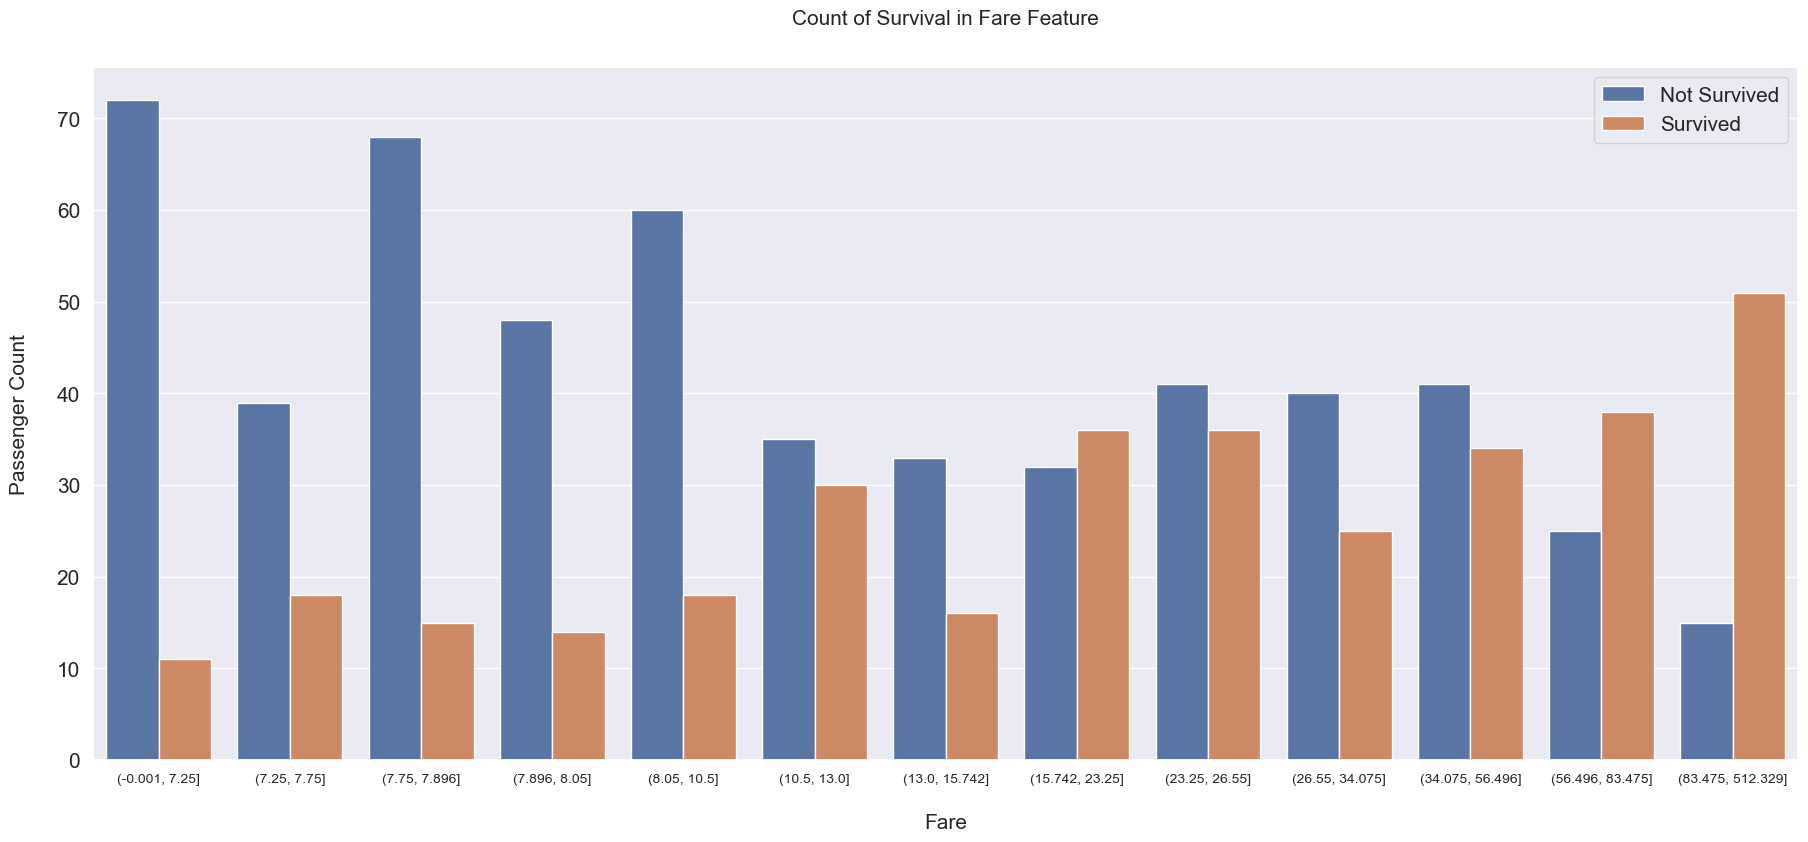

In [39]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

### IV. A. 2. Age

Age feature is normally distributed with some irregularities, and it's divided into 10 quantile-based bins. The bin with the highest survival rate is the first one, and the fourth bin has the lowest survival rate. 

These correspond to the most significant spikes in the distribution. Additionally, a peculiar group (34.0, 40.0] with a high survival rate is identified in this procedure.

In [40]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

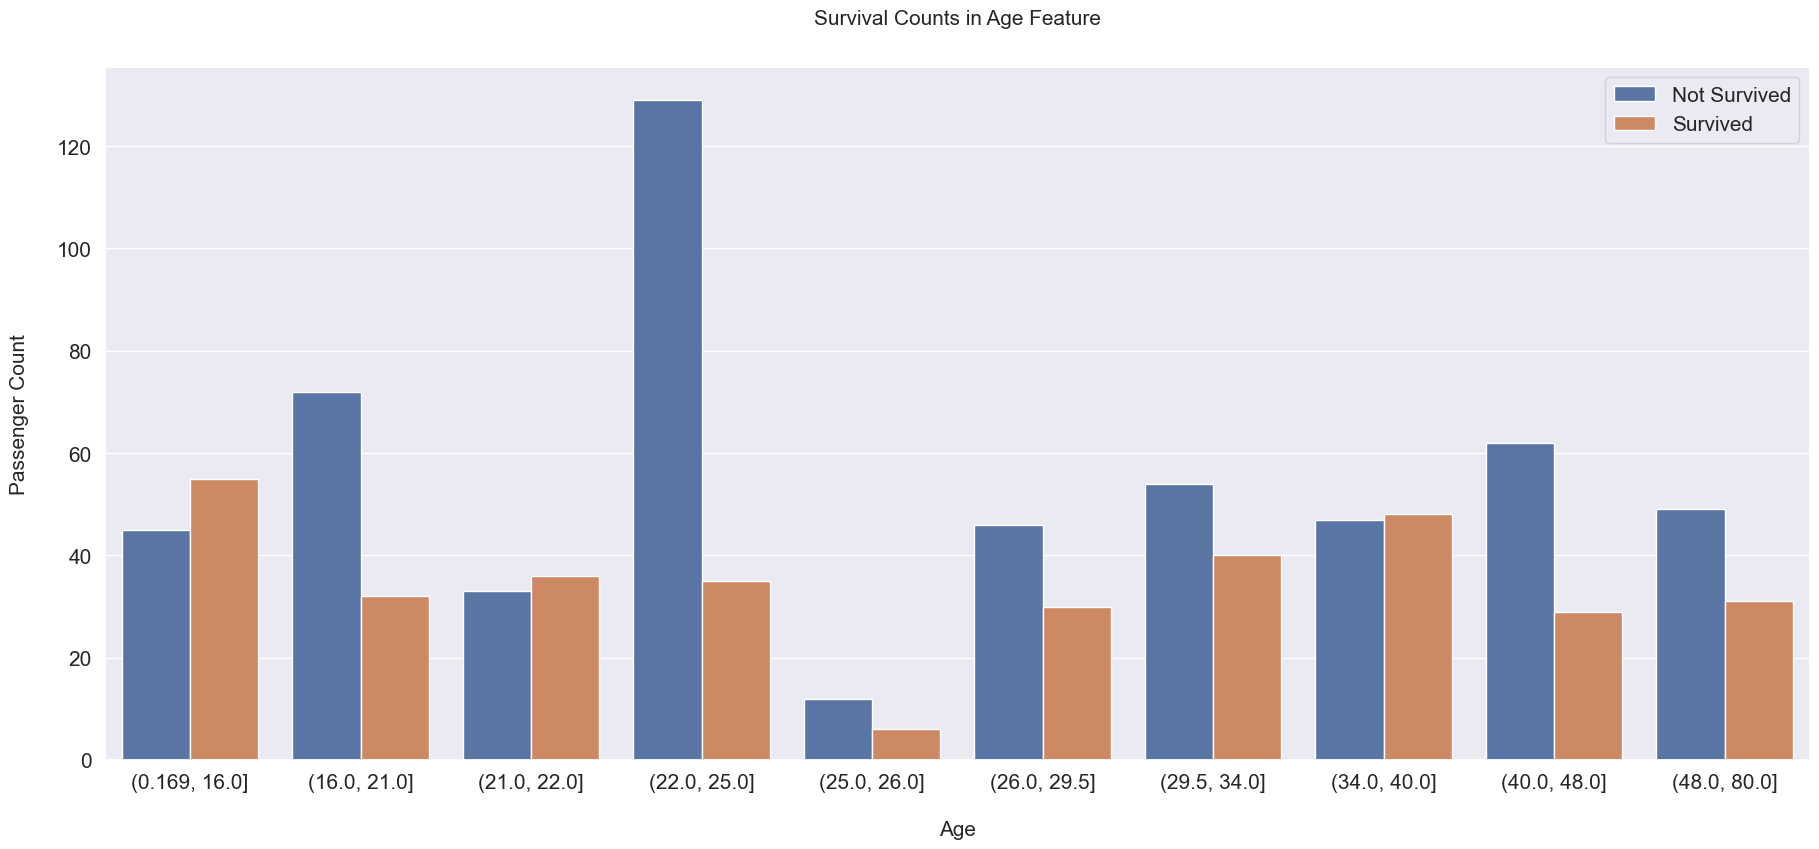

In [41]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## IV. B. Frequency Encoding

The Family_Size feature is constructed by adding the values of SibSp, Parch, and 1, where SibSp indicates the number of siblings and spouse, and Parch represents the number of parents and children. 

By adding these columns, we can determine the overall size of each family, including the current passenger. The graphs have demonstrated that the family size is a strong indicator of survival, as different family sizes have distinct survival rates.

- Family Size with 1 are labeled as Alone.


- Family Size with 2, 3 and 4 are labeled as Small.


- Family Size with 5 and 6 are labeled as Medium.


- Family Size with 7, 8 and 11 are labeled as Large.

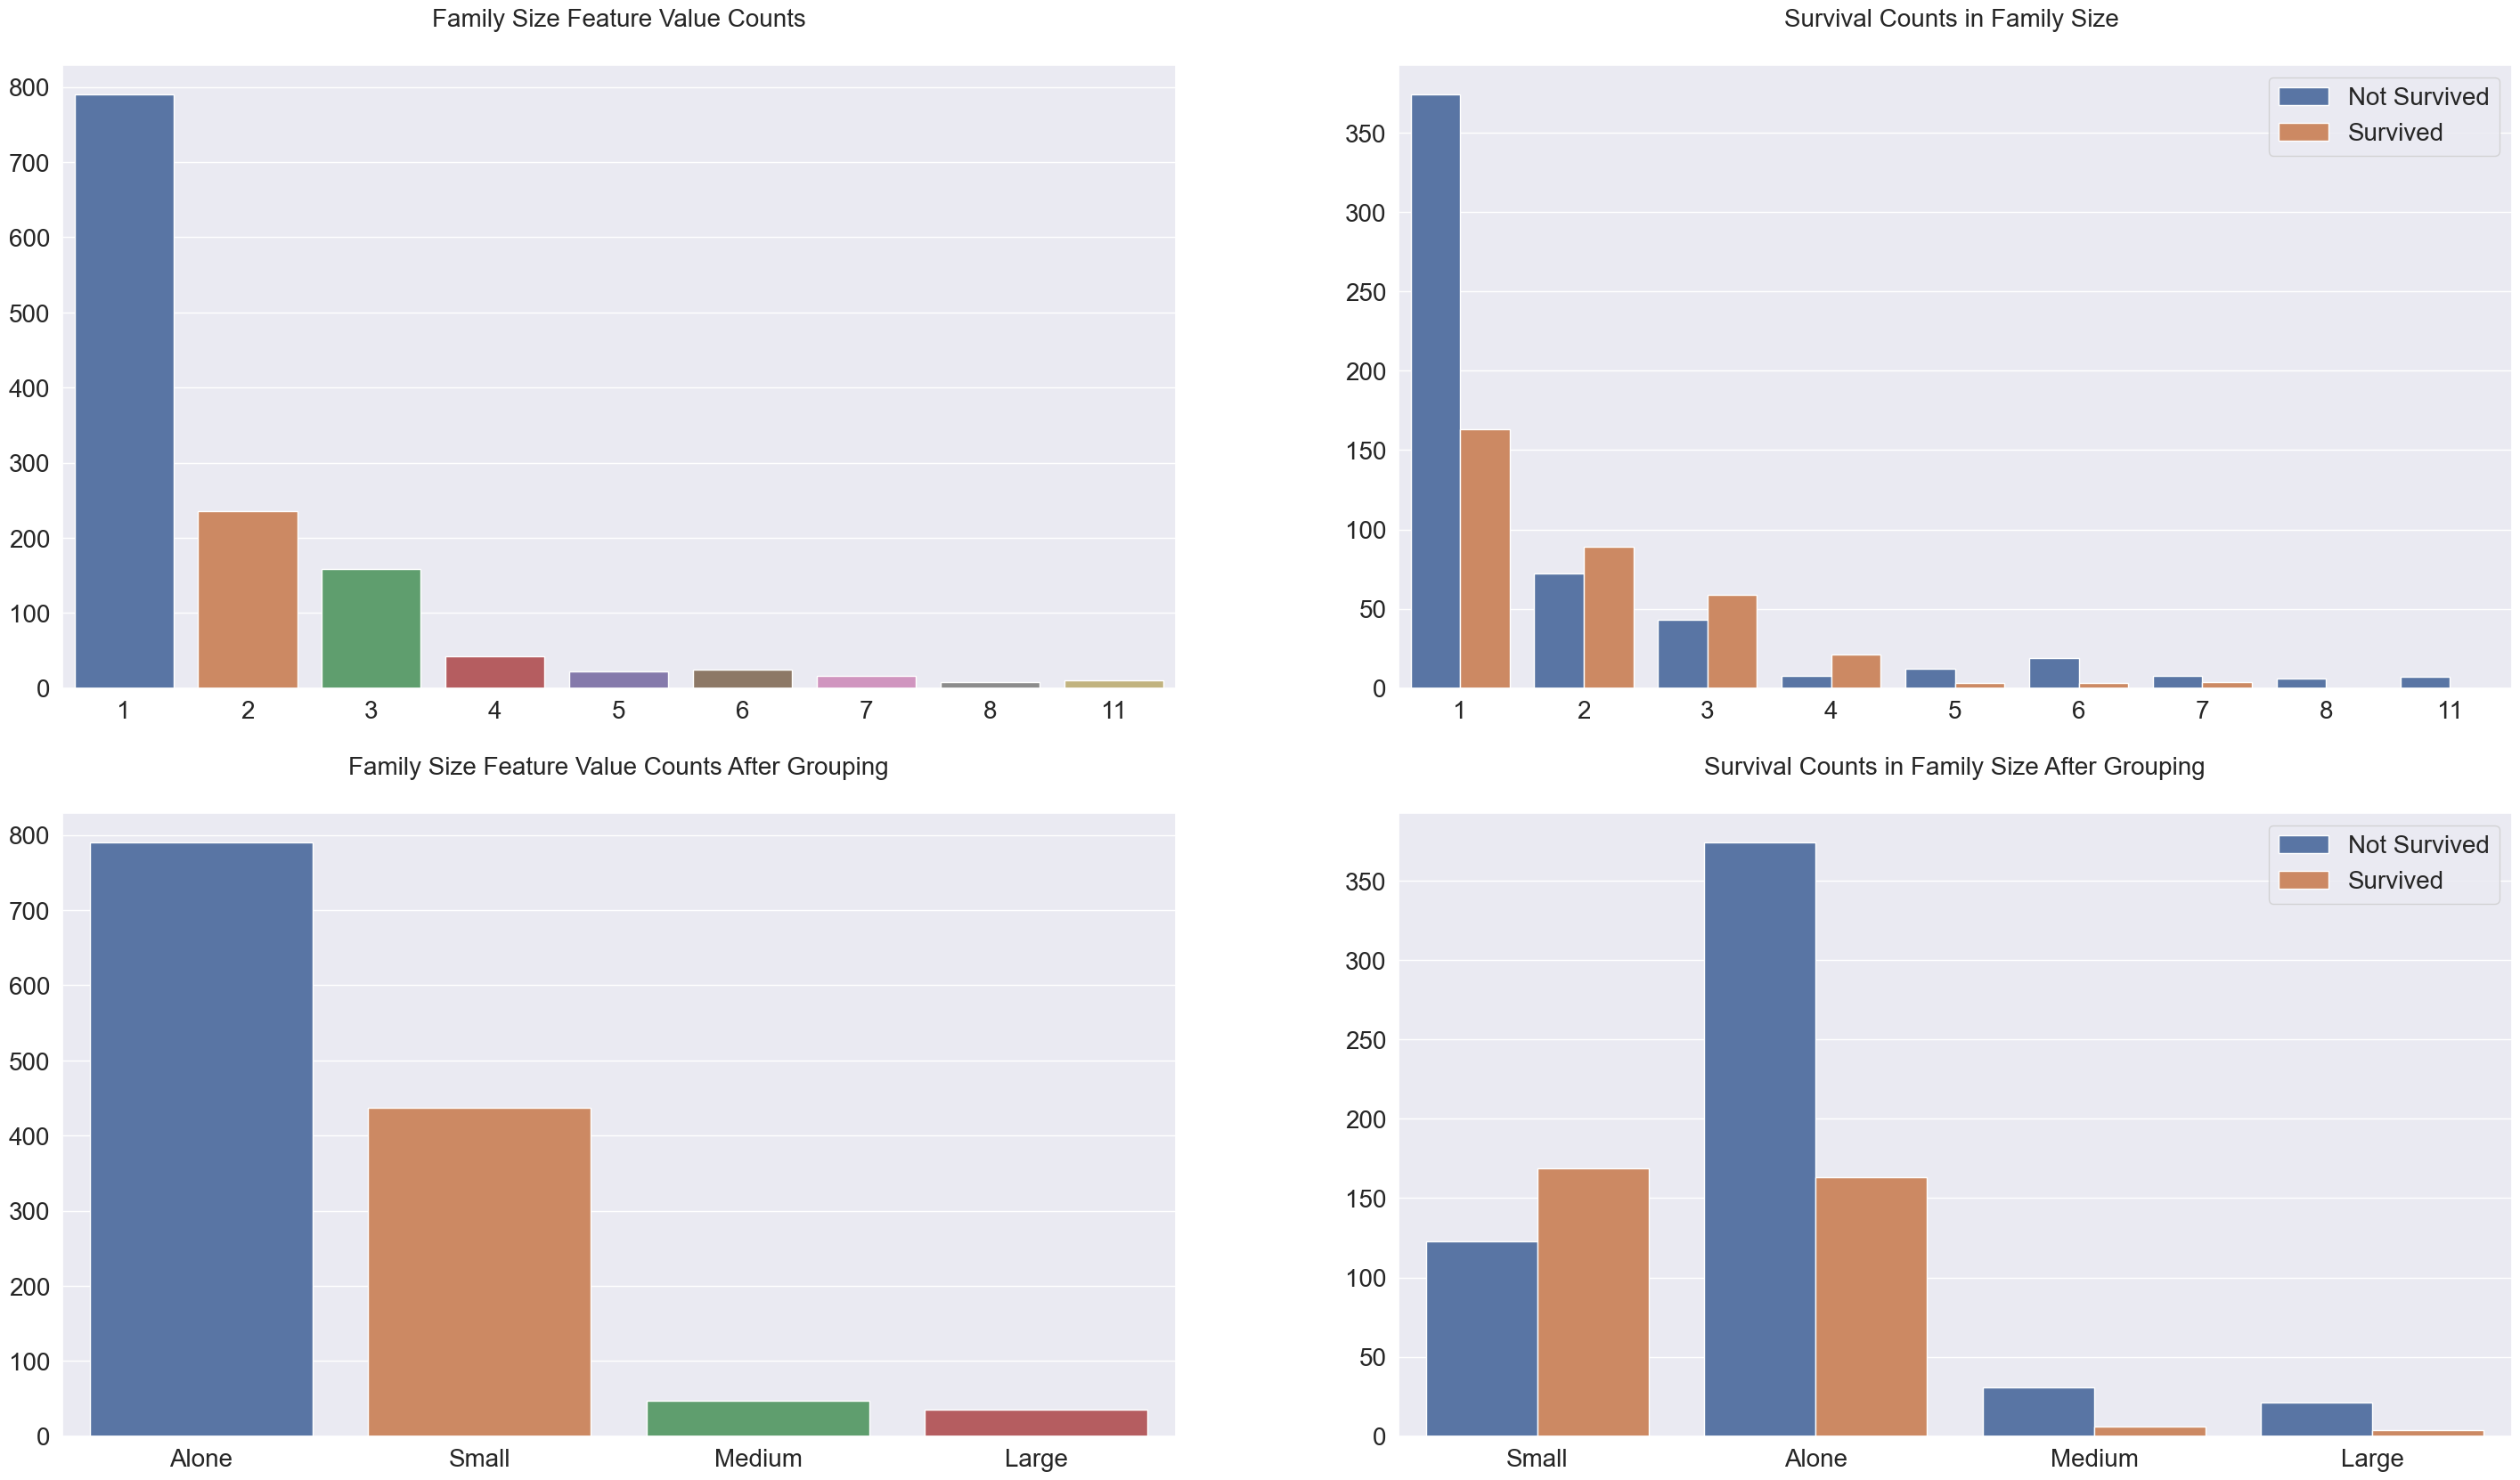

In [42]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

To simplify the analysis, the Ticket feature is grouped by their frequencies, as there are too many unique values to analyze.

Unlike Family_Size, this feature takes into account passengers who traveled with groups such as friends or maids, using the same ticket.

Grouping by ticket prefixes is not useful as any meaningful information is already captured by other features. 

The graph shows that groups of 2, 3, and 4 members had a higher survival rate, while passengers traveling alone had the lowest rate. Survival rates decrease drastically for groups larger than 4, and this pattern is similar to the Family_Size feature, with minor differences. 

Ticket_Frequency values are not grouped as that would create a feature with perfect correlation and no additional information gain.

In [43]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

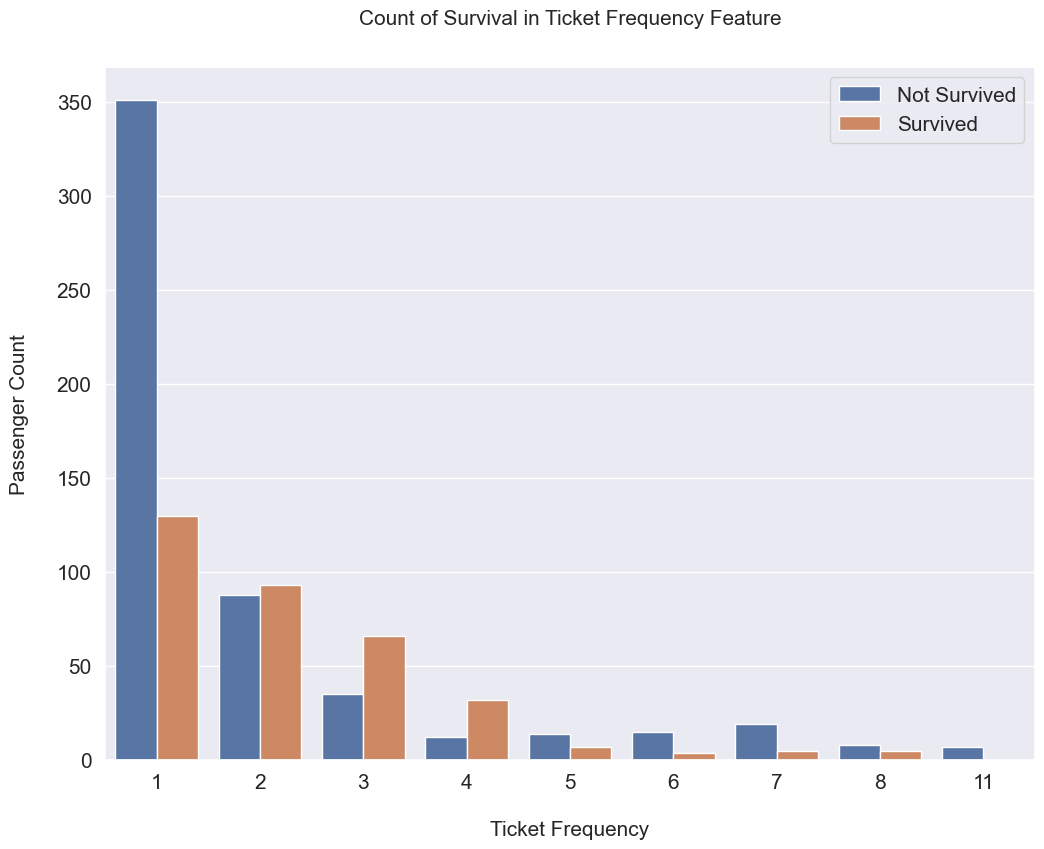

In [44]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

## IV. C. Title & Is Married

The Title feature is created by extracting the prefix from the Name feature. However, some titles occur very rarely and some of them are incorrect. 

To handle this, some titles are replaced with more common and appropriate ones. 

Female titles such as Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, and Dona are replaced with Miss/Mrs/Ms because they all refer to female passengers. Some titles like Mlle, Mme, and Dona are actually passenger names but are classified as titles due to the comma separation in the Name feature. 

Titles such as Dr, Col, Major, Jonkheer, Capt, Sir, Don, and Rev are replaced with Dr/Military/Noble/Clergy because these passengers have similar characteristics. 

The Master title is unique and given to male passengers below age 26 who have the highest survival rate among all males.

Is_Married is a binary feature based on the Mrs title. Mrs title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [45]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

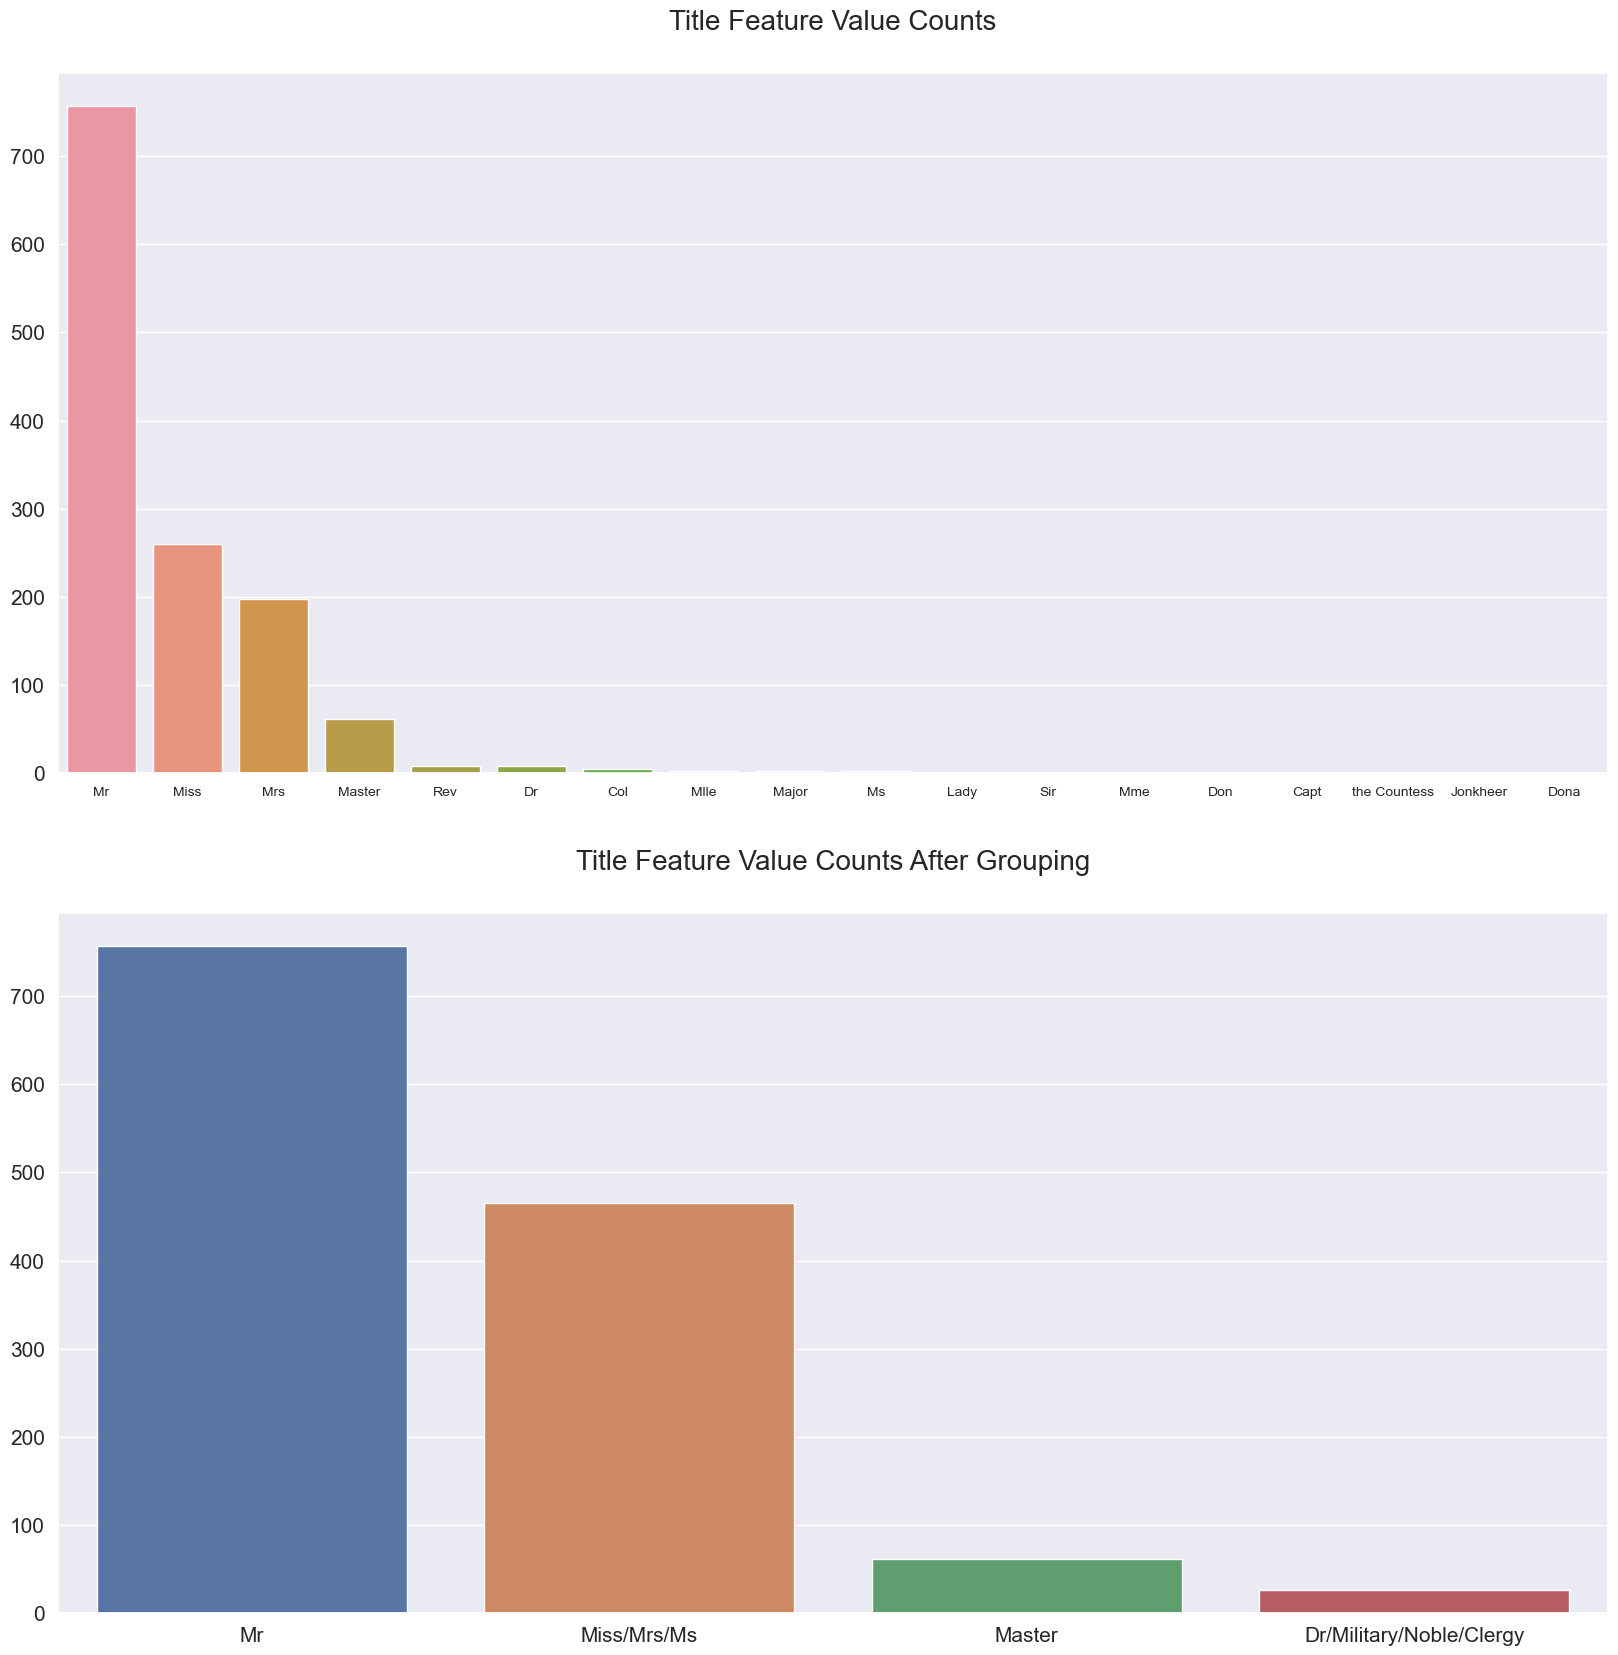

In [46]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

## IV. D. Target Encoding

The function "extract_surname" is usedd to extract the surnames of the passengers from the "Name" feature. 

Subsequently, the "Family" feature is generated based on the extracted surname. This step is crucial for grouping passengers who belong to the same family.

In [47]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

Family_Survival_Rate is calculated using the families present in the training set since the test set doesn't have the Survived feature. A list of family names that appear in both training and test set is generated (non_unique_families). The survival rate is calculated for the families with more than one member in this list, and the result is stored in the Family_Survival_Rate feature.


Furthermore, an additional binary feature called Family_Survival_Rate_NA is created for the families that are unique to the test set. This feature is required because there is no way to calculate the survival rate of these families. This feature indicates that the family survival rate cannot be applied to these passengers because it's impossible to retrieve their survival rate.

Similarly, Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are also created using the same method. The Ticket_Survival_Rate and Family_Survival_Rate are averaged to obtain the Survival_Rate, and Ticket_Survival_Rate_NA and Family_Survival_Rate_NA are also averaged to get Survival_Rate_NA.

In [48]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2   

## IV. E. Feature Transformation

### IV. E. 1. Label Encoding Non-Numerical Features

The features Embarked, Sex, Deck, Title, and Family_Size_Grouped are categorical features in object data type, while Age and Fare are numerical features in category data type. 

To enable the models to learn from these features, they need to be converted into numerical data types. This is achieved by using the LabelEncoder function, which assigns a label to each category, ranging from 0 to n. This labeling process allows the models to process and analyze the data in a way that is suitable for training and prediction.

In [49]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

### IV. E. 2. One-Hot Encoding the Categorical Features

To prepare the categorical features (Pclass, Sex, Deck, Embarked, Title) for machine learning models, they are transformed into one-hot encoded features using the OneHotEncoder. 

This creates a new binary feature for each unique value in the original feature. However, the Age and Fare features are not transformed with OneHotEncoder since they have a natural order and can be treated as ordinal variables.

In [50]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

## IV. F. Conclusion

The Age and Fare features were put into bins, which helped handle outliers and identify similar groups within the features. The Family_Size feature was created by adding the Parch and SibSp features together and then adding 1. Ticket_Frequency was generated by counting the number of occurrences of each Ticket value.

The Name feature was utilized to create two new features : Title and Is_Married. The Title was extracted from the title prefix in the passenger names. Family_Survival_Rate and Family_Survival_Rate_NA were generated by applying target encoding to the passengers' surnames. Ticket_Survival_Rate was created using target encoding on the Ticket feature. The Survival_Rate feature was produced by averaging Family_Survival_Rate and Ticket_Survival_Rate.

Finally, non-numeric features were label encoded, and categorical features were one-hot encoded. Five new features (Family_Size, Title, Is_Married, Survival_Rate, and Survival_Rate_NA) were created, and the useless features were dropped after encoding.

In [51]:
df_all = concat_df(df_train, df_test)

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

Age  Deck_1  Deck_2  Deck_3  Deck_4  Embarked_1  Embarked_2  Embarked_3  \
0    2     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
1    7     1.0     0.0     0.0     0.0         1.0         0.0         0.0   
2    4     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
3    7     1.0     0.0     0.0     0.0         0.0         0.0         1.0   
4    7     0.0     0.0     0.0     1.0         0.0         0.0         1.0   

   Family_Size_Grouped_1  Family_Size_Grouped_2  ...  Pclass_3  Sex_1  Sex_2  \
0                    0.0                    0.0  ...       1.0    0.0    1.0   
1                    0.0                    0.0  ...       0.0    1.0    0.0   
2                    1.0                    0.0  ...       1.0    1.0    0.0   
3                    0.0                    0.0  ...       0.0    1.0    0.0   
4                    1.0                    0.0  ...       1.0    0.0    1.0   

   Survival_Rate  Survival_Rate_NA  Ticket_Frequency  Title_1  Title_2  \
0       0.383838               0.0                 1      0.0      0.0   
1       1.000000               1.0                 2      0.0      0.0   
2       0.383838               0.0                 1      0.0      0.0   
3       0.383838               0.0                 2      0.0      0.0   
4       0.383838               0.0                 1      0.0      0.0   

   Title_3  Title_4  
0      0.0      1.0  
1      1.0      0.0  
2      1.0      0.0  
3      1.0      0.0  
4      0.0      1.0  

[5 rows x 26 columns]

# V. Modelling

For the modelling stage of this project, we will be using Scikit-learn, a widely-used Python library for machine learning. Since the problem we are tackling is a classification task, we need to employ classification models, also referred to as classifiers, to train our model and make predictions. 

To learn more about the various machine learning models offered by Scikit-learn, I suggest referring to their documentation.

In [52]:
df_all = concat_df(df_train, df_test)

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

Age  Deck_1  Deck_2  Deck_3  Deck_4  Embarked_1  Embarked_2  Embarked_3  \
0    2     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
1    7     1.0     0.0     0.0     0.0         1.0         0.0         0.0   
2    4     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
3    7     1.0     0.0     0.0     0.0         0.0         0.0         1.0   
4    7     0.0     0.0     0.0     1.0         0.0         0.0         1.0   

   Family_Size_Grouped_1  Family_Size_Grouped_2  ...  Pclass_3  Sex_1  Sex_2  \
0                    0.0                    0.0  ...       1.0    0.0    1.0   
1                    0.0                    0.0  ...       0.0    1.0    0.0   
2                    1.0                    0.0  ...       1.0    1.0    0.0   
3                    0.0                    0.0  ...       0.0    1.0    0.0   
4                    1.0                    0.0  ...       1.0    0.0    1.0   

   Survival_Rate  Survival_Rate_NA  Ticket_Frequency  Title_1  Title_2  \
0       0.383838               0.0                 1      0.0      0.0   
1       1.000000               1.0                 2      0.0      0.0   
2       0.383838               0.0                 1      0.0      0.0   
3       0.383838               0.0                 2      0.0      0.0   
4       0.383838               0.0                 1      0.0      0.0   

   Title_3  Title_4  
0      0.0      1.0  
1      1.0      0.0  
2      1.0      0.0  
3      1.0      0.0  
4      0.0      1.0  

[5 rows x 26 columns]

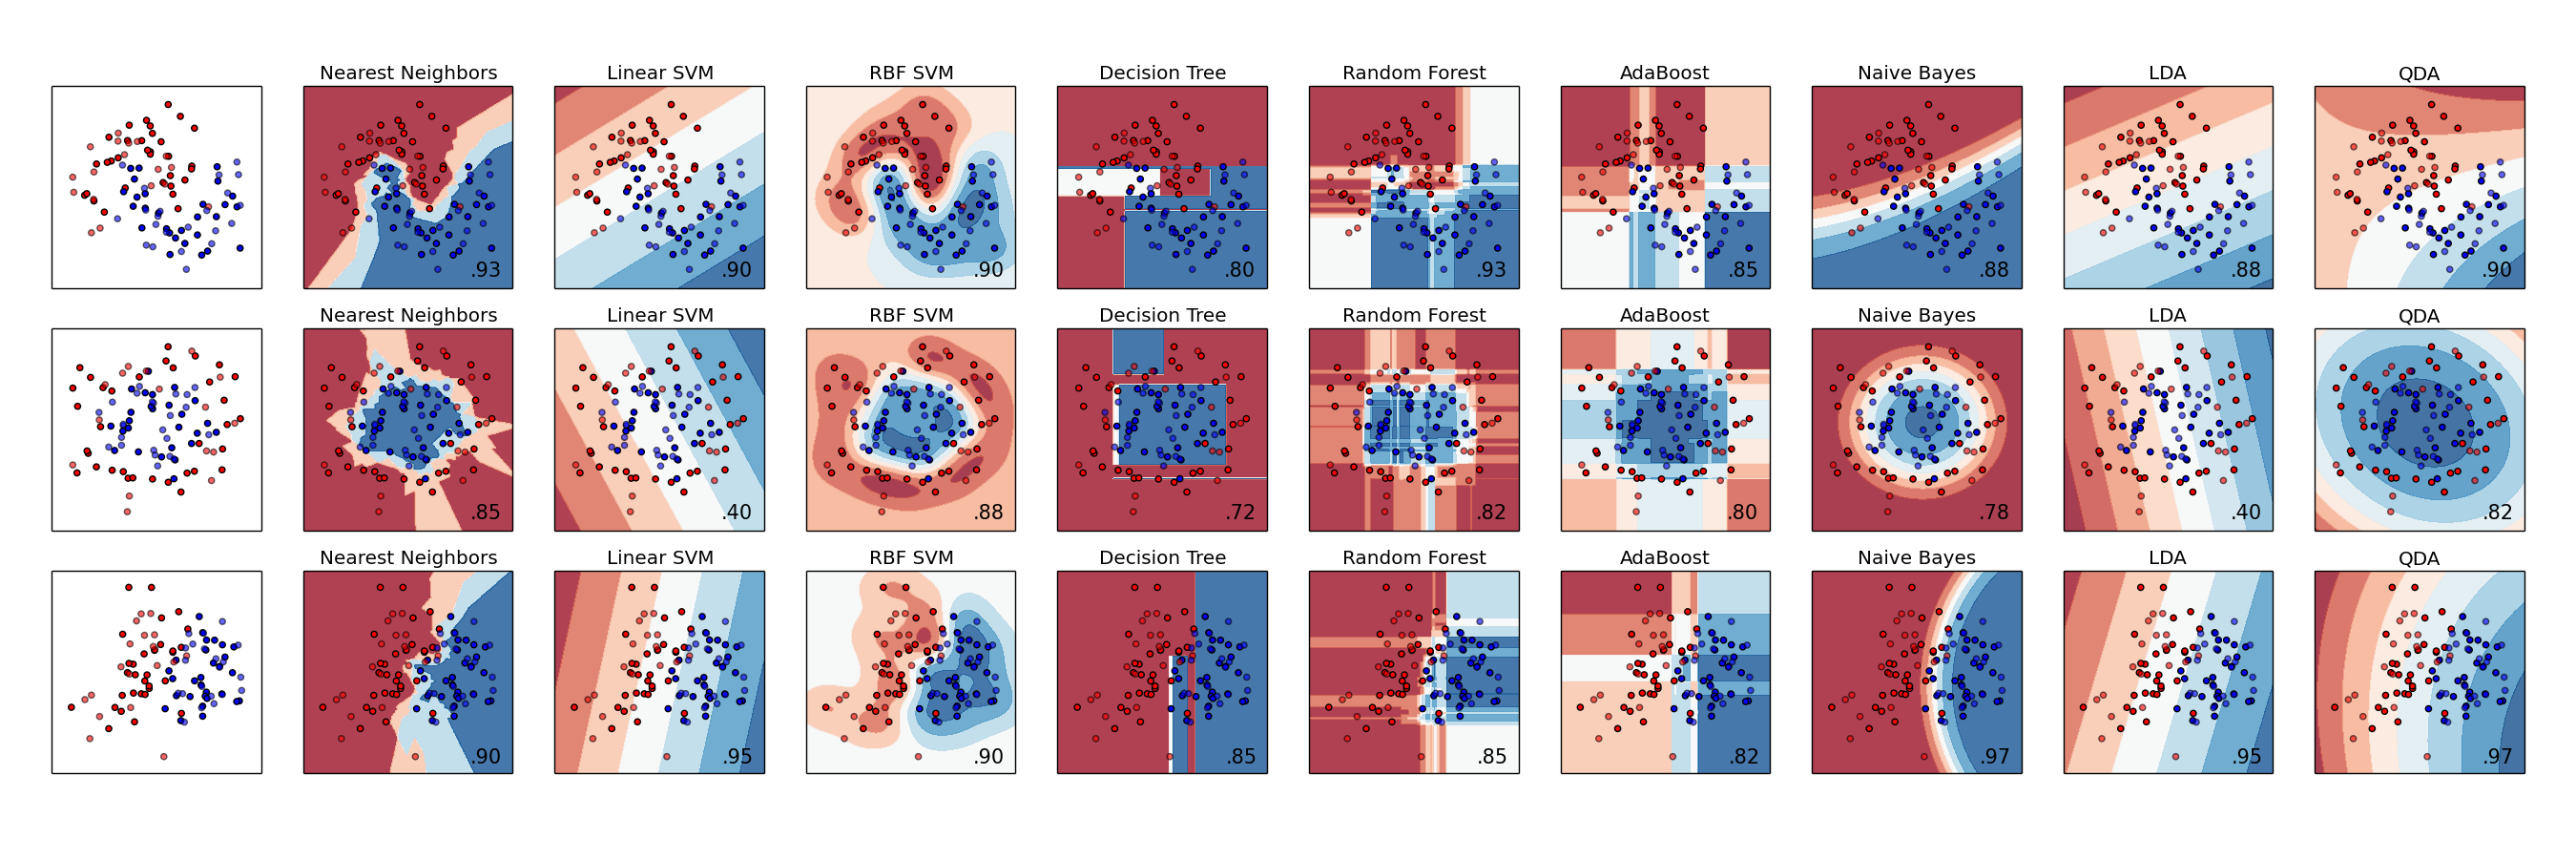

I have selected the following classifiers, which will be evaluated to determine which ones yield the best performance. Additionally, we will perform hyperparameter tuning to optimize the parameters of the models and improve their performance :

- Logistic regression
- Support vector machines
- K-nearest neighbours
- Gaussian naive bayes
- Perceptron
- Linear SVC
- Stochastic gradient descent
- Decision tree
- Random forest

The image above contains just some of the classifiers and how they separate the data.

## V. A. Split training data

We will split our training data into independent variables or predictor variables, represented by X as well as dependent variable or response variable, represented by Y.

We are also using StandardScaler to normalize our data and put it on the same scale. This is important for some models such as Support Vector Machines which require data normalization for effective training. Without normalization, these models may not perform well.

y_train is the survived column in our training set and X_train is the other columns in the training set excluding the Survived column. Our models will learn to classify survival, y_train based on all X_train and make predictions on X_test.

The train_test_split is only for choosing the best models. We will split the training data again later.

In [53]:
X = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y = df_train['Survived'].values

print('X_train shape: {}'.format(X.shape))
print('y_train shape: {}'.format(y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train shape: (891, 26)
y_train shape: (891,)


## V. B. Choosing the best models

This requires 3 steps : instantiate the model, fit the model to the training set and predict the data in test set. 

For each model, I will show you the classification report and his confusion matrix.

In [54]:
# Function to display classification report and his confusion matrix

def classification_score_report_confusion_matrix(score, Y_pred):
    print("Accuracy score :", score)
    print('-'*70)
    print(classification_report(y_test, Y_pred))
    cm = confusion_matrix(y_test, Y_pred)
    cm_df = pd.DataFrame(cm, ['Actual : Not survived ', 'Actual : Survived'], ['Predicted : Not survived', 'Predicted : Survived'])
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')

### V. B. 1. Logistic regression

Accuracy score : 86.03
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89       110
         1.0       0.81      0.83      0.82        69

    accuracy                           0.86       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.86      0.86       179



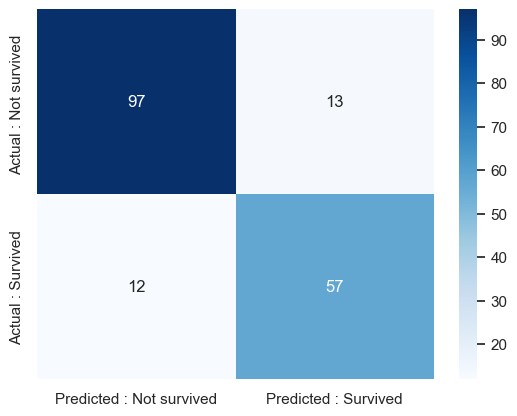

In [55]:
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train)
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_log, Y_pred_logreg)

### V. B. 2. Support vector machines

Accuracy score : 83.8
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       110
         1.0       0.79      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



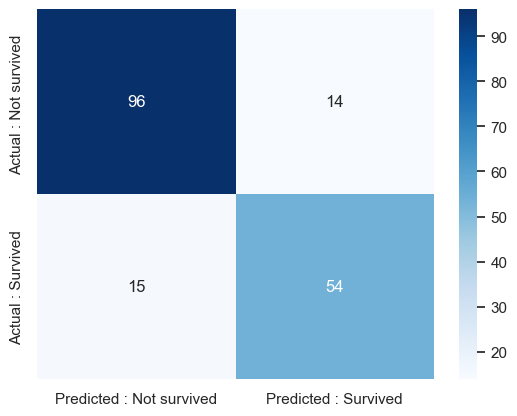

In [56]:
svc = SVC(random_state=0) # rbf by default
svc.fit(X_train, y_train)
Y_pred_svc = svc.predict(X_test)
acc_svc = round(svc.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_svc, Y_pred_svc)

### V. B. 3. K-nearest neighbours (KNN)

Accuracy score : 84.92
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       110
         1.0       0.85      0.74      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



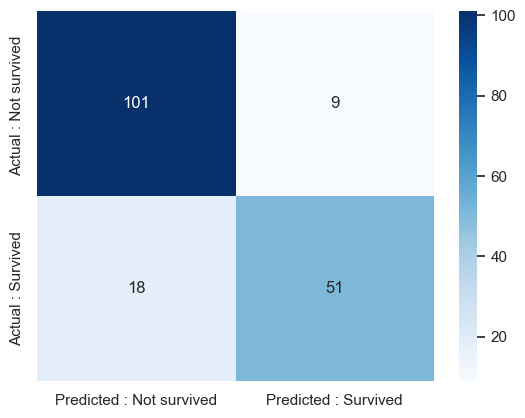

In [57]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_knn, Y_pred_knn)

### V. B. 4. Gaussian naive bayes

Accuracy score : 85.47
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.87       110
         1.0       0.77      0.90      0.83        69

    accuracy                           0.85       179
   macro avg       0.85      0.86      0.85       179
weighted avg       0.87      0.85      0.86       179



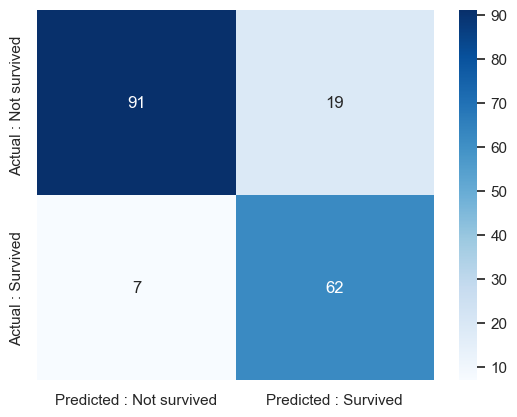

In [58]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_gaussian, Y_pred_gaussian)

### V. B. 5. Perceptron

Accuracy score : 78.21
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       110
         1.0       0.75      0.65      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



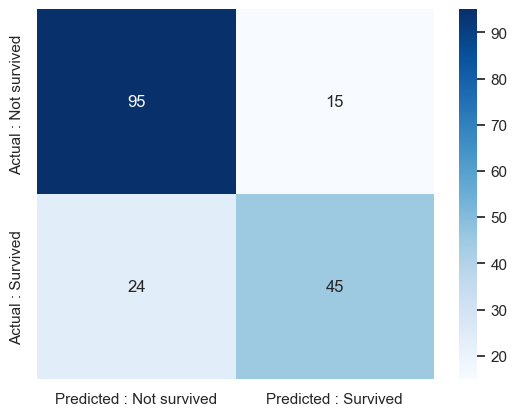

In [59]:
perceptron = Perceptron(random_state=0)
perceptron.fit(X_train, y_train)
Y_pred_perceptron = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_perceptron, Y_pred_perceptron)

### V. B. 6. Linear SVC

Accuracy score : 86.03
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89       110
         1.0       0.81      0.83      0.82        69

    accuracy                           0.86       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.86      0.86       179



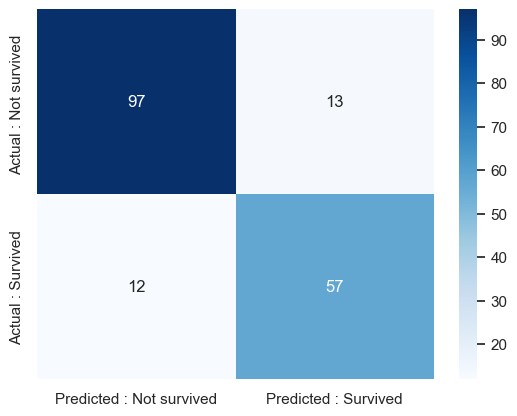

In [60]:
linear_svc = LinearSVC(random_state=0)
linear_svc.fit(X_train, y_train)
Y_pred_linear_svc = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_linear_svc, Y_pred_linear_svc)

### V. B. 7. Stochastic gradient descent

Accuracy score : 78.77
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       110
         1.0       0.71      0.75      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



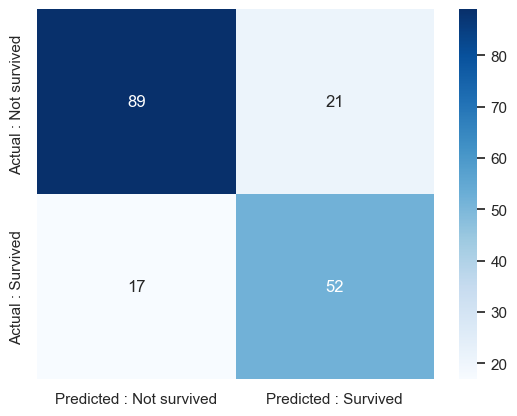

In [61]:
sgd = SGDClassifier(random_state=0)
sgd.fit(X_train, y_train)
Y_pred_sgd = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_sgd, Y_pred_sgd)

### V. B. 8. Decision tree

Accuracy score : 82.12
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       110
         1.0       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



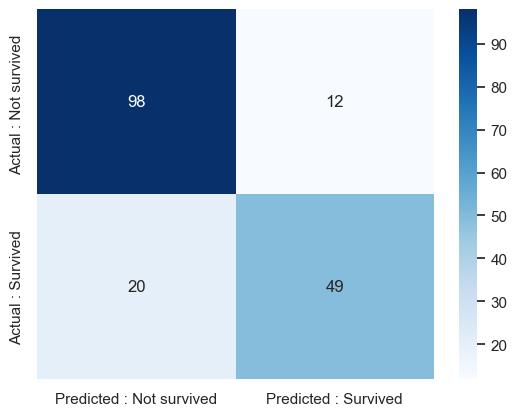

In [62]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)
Y_pred_decision_tree = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_decision_tree, Y_pred_decision_tree)

### V. B. 9. Random forest

Accuracy score : 86.59
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89       110
         1.0       0.86      0.78      0.82        69

    accuracy                           0.87       179
   macro avg       0.86      0.85      0.86       179
weighted avg       0.87      0.87      0.86       179



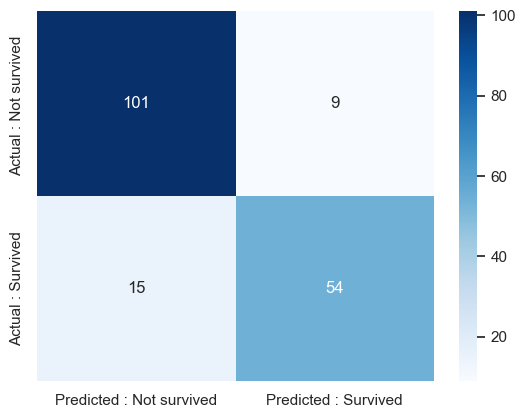

In [63]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train, y_train)
Y_pred_random_forest = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_random_forest, Y_pred_random_forest)

### V. B. 10. Extra Trees

Accuracy score : 83.8
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       110
         1.0       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



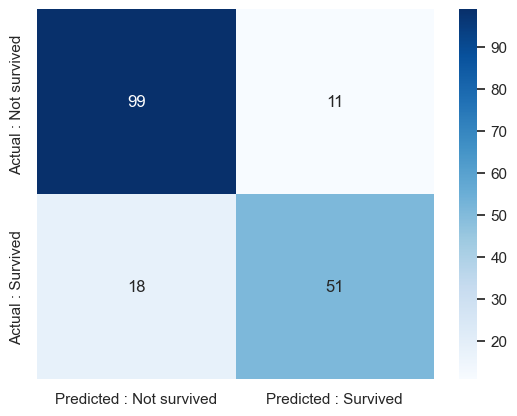

In [64]:
extra_trees = ExtraTreesClassifier(random_state=0)
extra_trees.fit(X_train, y_train)
Y_pred_extra_trees = extra_trees.predict(X_test)
acc_extra_trees = round(extra_trees.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_extra_trees, Y_pred_extra_trees)

### V. B. 11. AdaBoost

Accuracy score : 83.8
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87       110
         1.0       0.78      0.81      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



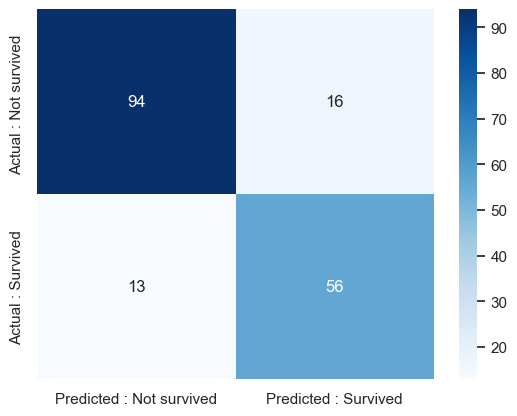

In [65]:
adaboost = AdaBoostClassifier(random_state=0)
adaboost.fit(X_train, y_train)
Y_pred_adaboost = adaboost.predict(X_test)
acc_adaboost = round(adaboost.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_adaboost, Y_pred_adaboost)

### V. B. 12. Gradient Boost

Accuracy score : 86.03
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       110
         1.0       0.85      0.77      0.81        69

    accuracy                           0.86       179
   macro avg       0.86      0.84      0.85       179
weighted avg       0.86      0.86      0.86       179



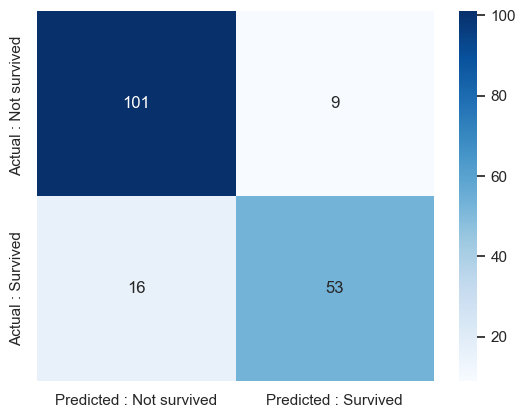

In [66]:
gradient_boost = GradientBoostingClassifier(random_state=0)
gradient_boost.fit(X_train, y_train)
Y_pred_gradient_boost = gradient_boost.predict(X_test)
acc_gradient_boost = round(gradient_boost.score(X_test, y_test) * 100, 2)
classification_score_report_confusion_matrix(acc_gradient_boost, Y_pred_gradient_boost)

I will plot an histogram in order to have a better visualization.

In [67]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'Extra Trees', 'AdaBoost', 'Gradient Boosting'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_extra_trees, acc_adaboost, acc_gradient_boost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

Model  Score
0                Random Forest  86.59
1          Logistic Regression  86.03
2                   Linear SVC  86.03
3            Gradient Boosting  86.03
4                  Naive Bayes  85.47
5                          KNN  84.92
6      Support Vector Machines  83.80
7                  Extra Trees  83.80
8                     AdaBoost  83.80
9                Decision Tree  82.12
10  Stochastic Gradient Decent  78.77
11                  Perceptron  78.21

We will use the Random Forest model for our prediction.

## V. C. Hyperparameter tunning, Cross-validation, Learning Curve

### V. C. 1. Hyperparameter tunning

Created 2 RandomForestClassifier's. One of them is a single model and the other is for K-fold cross validation.

I spare you the hyperparameter tunning with GridSearchCV that took too long. If you really want to find out what is the best parameters, here's the code with empty values so that you can find yourself your parameters that you want to adjust.

In [68]:
rf = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=0,
                                           n_jobs=-1,
                                           verbose=1)

### V. C. 2. Cross-validation

Cross-validation is a technique used to evaluate the performance of a machine learning model by splitting the dataset into multiple subsets. One subset is used as a testing set while the remaining subsets are used for training the model. This process is repeated several times, with each subset being used for testing. The results are then averaged to get a more accurate estimate of the model's performance. The main advantage of cross-validation is that it helps to reduce overfitting and provides a more accurate estimate of a model's performance on unseen data.

Before we do the cross-validation, I will split the training data again to avoid using the X_train, X_test and y_train from the train_test_split.

In [69]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


K-Fold cross-validation is a technique whereby a subset of our training set is kept aside and will act as holdout set for testing purposes. However, we wil use StratifiedKFold which is a variation of the K-Fold cross-validation method.

StratifiedKFold is a type of cross-validation technique where each fold is made by preserving the proportion of classes in each subset. He will ensures that the distribution of classes is consistent across all the folds, and can help prevent overfitting or underfitting in a model.

In [72]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    rf.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], rf.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], rf.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = rf.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = rf.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = rf.feature_importances_
        
    oob += rf.oob_score_/ N
    print('Fold {} OOB Score : {:.2%}\n'.format(fold, rf.oob_score_))
    
print('Average OOB Score : {:.2%}'.format(oob))


Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 1 OOB Score : 85.81%

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 2 OOB Score : 84.99%

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 3 OOB Score : 85.41%

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 4 OOB Score : 83.87%

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Fold 5 OOB Score : 83.59%

Average OOB Score : 84.74%


[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished


### V. C. 2. Learning Curve

The learning curve shows the performance of the model as the size of the training set increases. The horizontal axis represents the number of samples in the training set, while the vertical axis represents the cross-validated score.

The red line represents the training score, which indicates the performance of the model on the training set as it is trained on increasing amounts of data. As expected, the training score initially starts off high, but then gradually decreases as the model sees more data. This is because the model may start to overfit as it is given more and more data to train on.

The green line represents the cross-validation score, which indicates how well the model generalizes to new data. As the training set size increases, the cross-validation score initially improves, as the model is given more data to learn from. However, after a certain point, adding more data does not lead to any significant improvement in the cross-validation score. This is because the model has already learned all it can from the existing data, and additional data does not add any new information.

Overall, the learning curve helps us understand how well our model is learning from the data, and whether we are overfitting or underfitting. If the training score and cross-validation score are both low, it indicates that the model is underfitting, and we may need to use a more complex model or add more features. If the training score is high but the cross-validation score is low, it indicates that the model is overfitting, and we may need to use regularization techniques or get more training data.

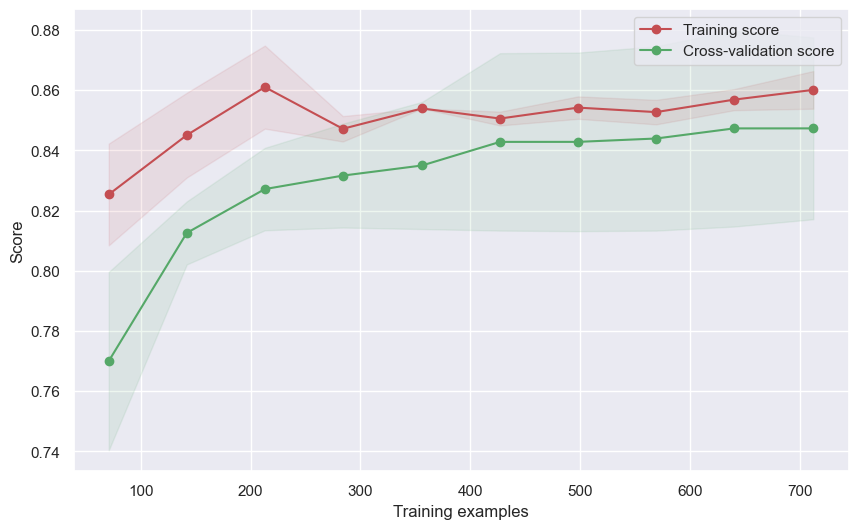

In [73]:
# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=rf,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)

# Compute the mean and standard deviation of the train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

##  V. D. Feature Importance

It's interesting to watch which feature is important in your model so that you can adapt your feature and improve your model.

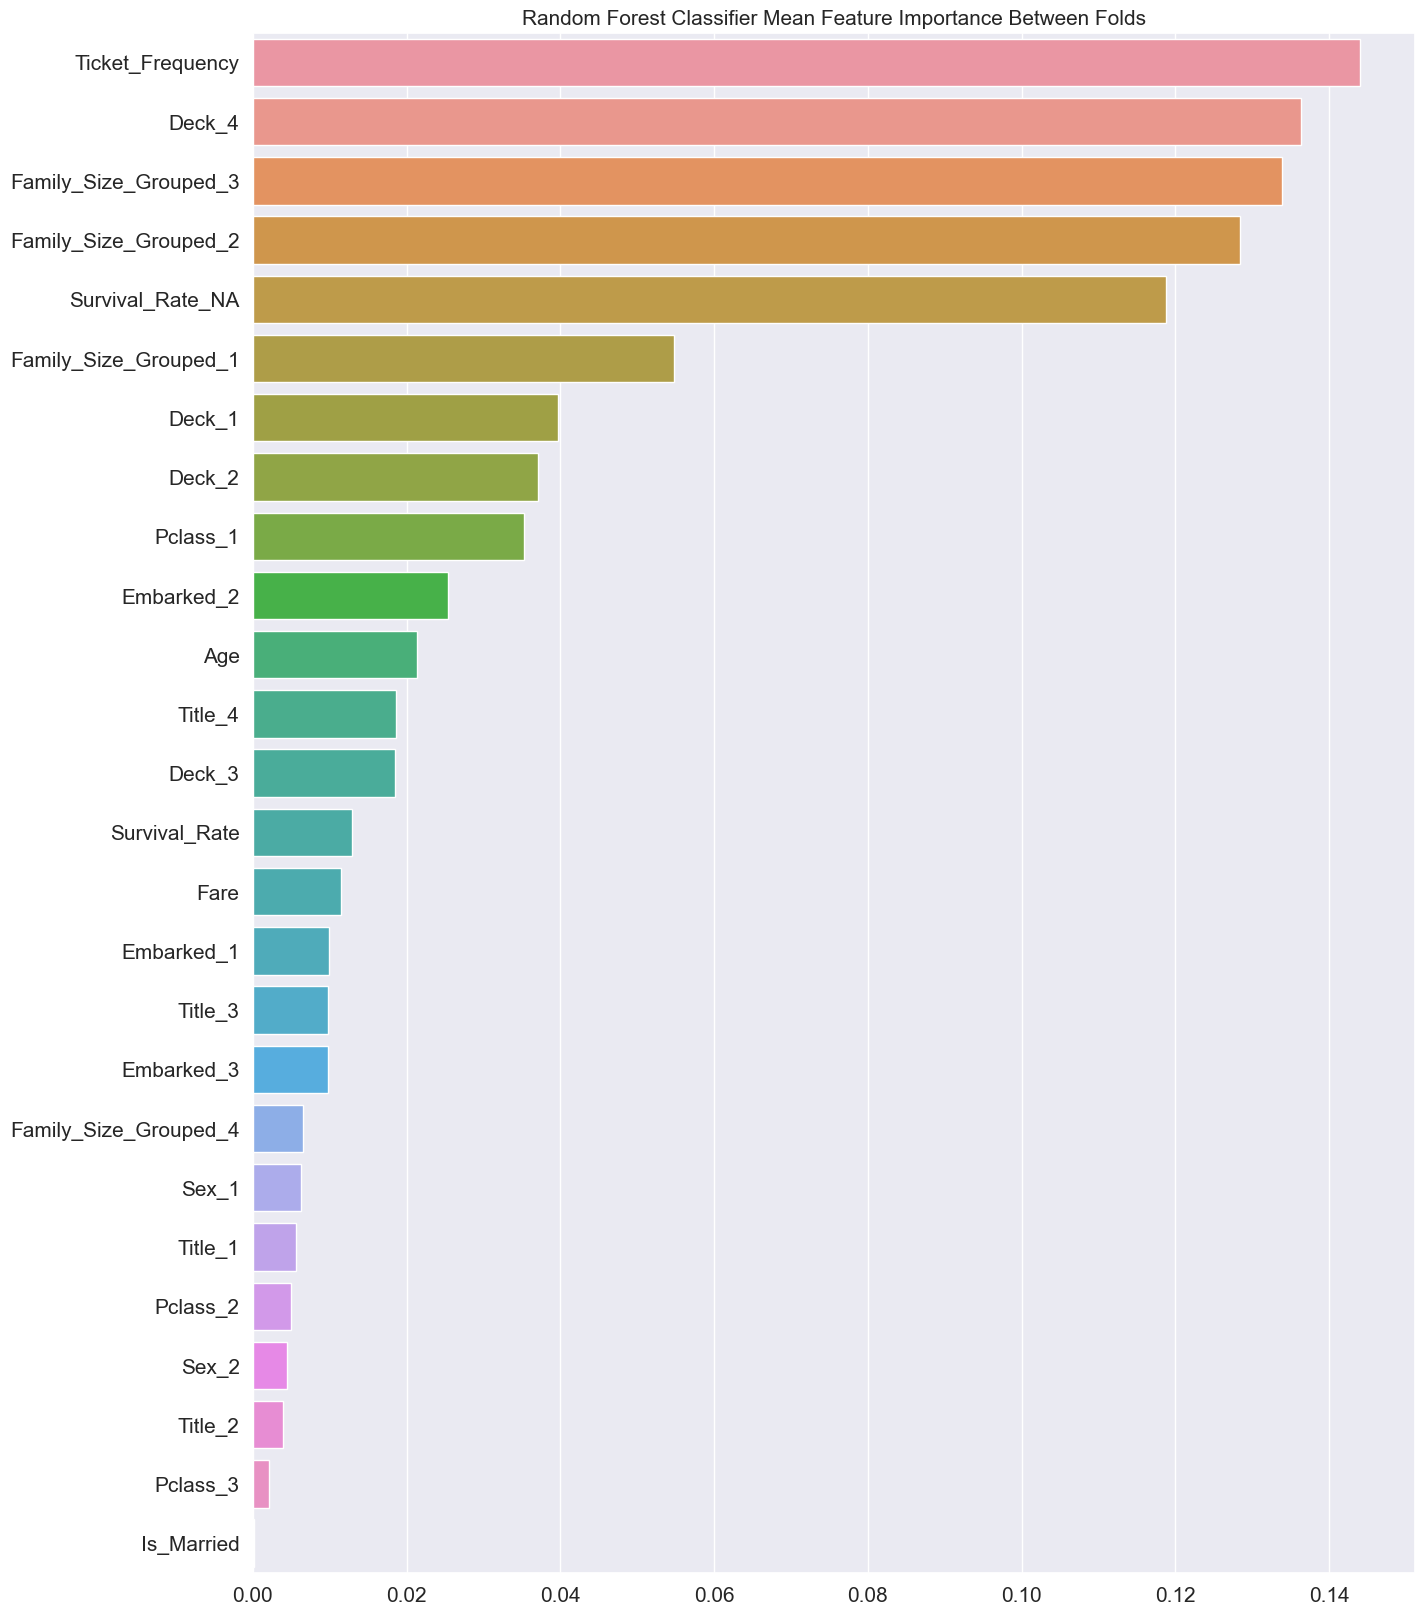

In [74]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

##  V. E. ROC (Receiver Operating Characteristic) Curve

The ROC curve is a graphical representation of the performance of a binary classifier system as the discrimination threshold is varied. It is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true positive rate is the proportion of actual positive cases that are correctly identified as such, while the false positive rate is the proportion of negative cases that are incorrectly classified as positive.

The ROC curve is a useful tool for evaluating the performance of a binary classifier system as it provides a visual summary of the trade-off between the true positive rate and the false positive rate. A perfect classifier system would have an ROC curve that passes through the upper left corner of the plot, representing a TPR of 1 and an FPR of 0. The closer the curve is to the upper left corner, the better the performance of the classifier system. The area under the ROC curve (AUC) is a measure of the overall performance of the classifier system, with an AUC of 1 indicating perfect performance and an AUC of 0.5 indicating random chance.

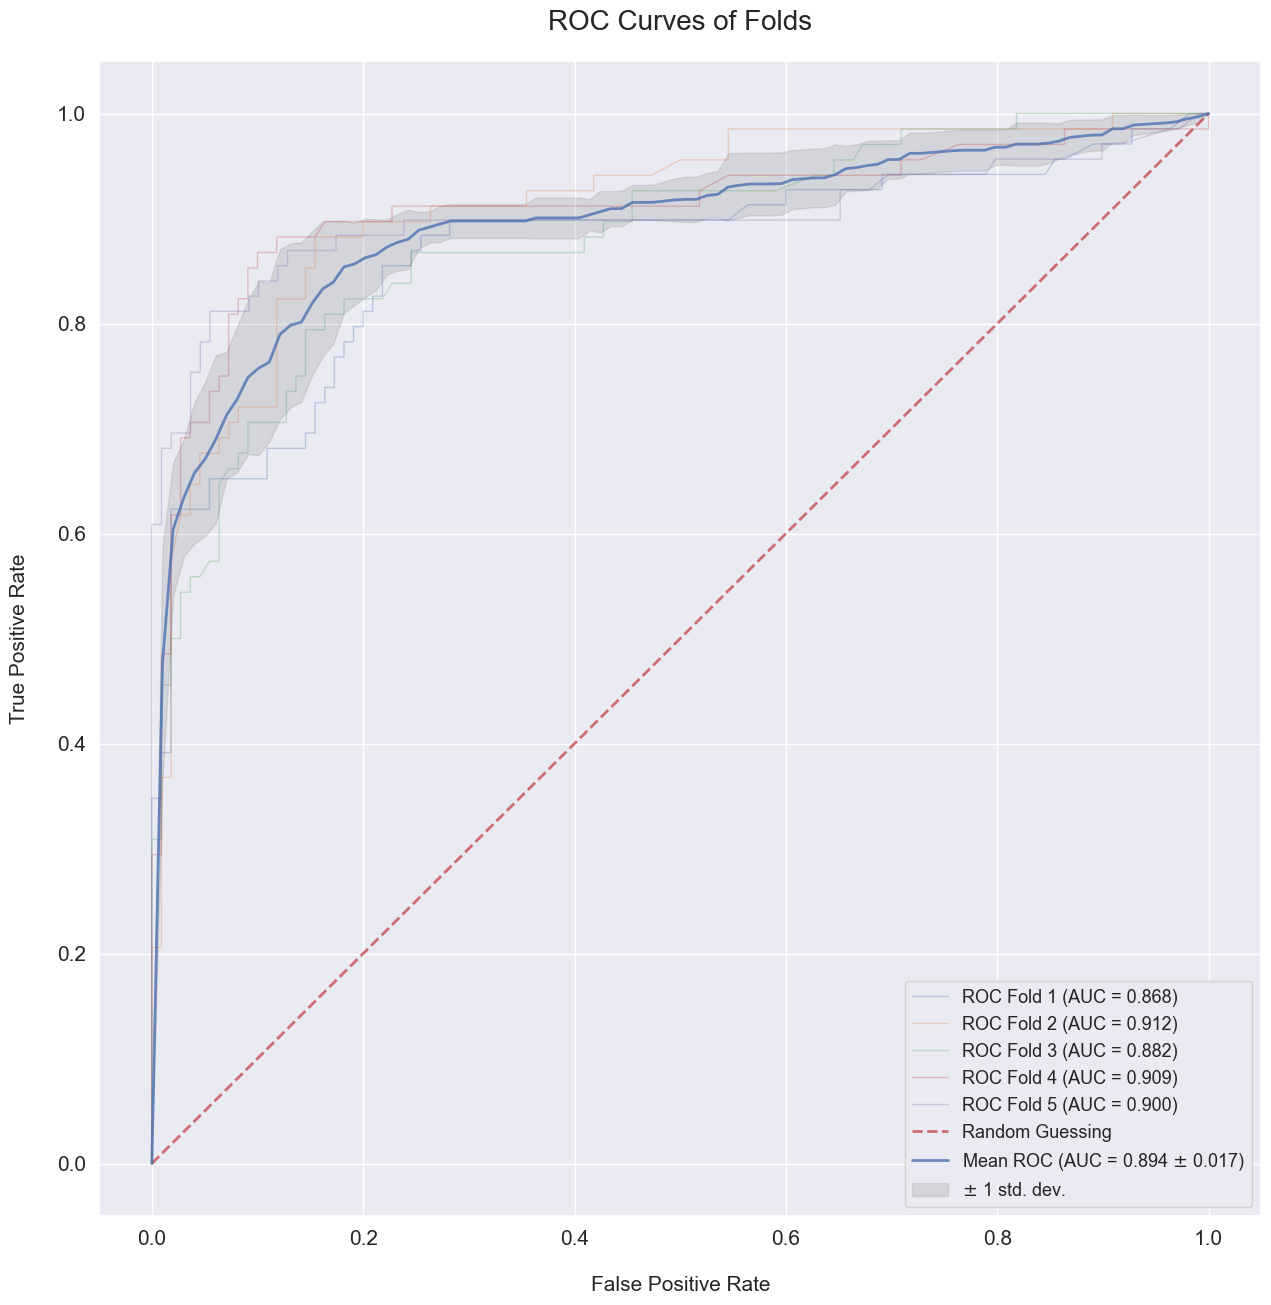

In [75]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

# VI. Submission

In [ ]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

**Normally, if you follow exactly this notebook, you will get 0.81339 score in Kaggle.**

# VII. Conclusion

This dataset is a good start for beginners who want to become data scientists or data analysts. 

In my opinion, the most difficult part is during the preprocessing stage because this is where the model will have a huge influence. Most of the problems you will have to deal with are related to shape, so be cautious when using the .shape function, and also use .head() if you can. 

Hyperparameter tuning is also a difficult part to deal with, but it will come with experience. 

I hope this notebook will help you in the future.